# Estimate SEIR parameters from data for different countries

In [1]:
%run ./Load-Data.ipynb

In [2]:
from enum import Enum
class GammaOption(Enum):
    MEAN_GAMMA = 1
    GAMMA_T = 2
    SEARCH = 3
    
#Run parameters
runForAllCountries = True
runWithGammaOption=GammaOption.GAMMA_T
stepSizesToRunFor = [-1, 7, 21, 14]

In [3]:
from matplotlib import pyplot
%matplotlib inline

pyplot.style.use("fivethirtyeight")# for pretty graphs

# Increase the default plot size and set the color scheme
pyplot.rcParams['figure.figsize'] = 8, 15

In [4]:
%run ./SEIR.ipynb
def predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values):
    if(S_E_I_R_values is not None):
        init_vals = S_E_I_R_values
    else:
        init_vals = N-1, 1, 0, 0
    params = alpha, beta, gamma,gammaT 
   
    t = np.arange(nSteps)
    results = population_seir_model(init_vals, params, t, N)
    return results

In [5]:
def computeGamma(infected, removed, axs):    
    return computeGammaT(infected, removed, axs).mean()

In [6]:
def computeGammaT(infected, removed, axs):    
    dR_dt= np.diff(removed)
    infected[infected == 0] = 1 # to prevent divide by zero
    gammaT = dR_dt / infected[0:-1]
    if len(gammaT[gammaT > 1]) > 0:
        print('gammaT', gammaT)
        print('infected', infected[0:-1])
        print('dR_dt', dR_dt)
    return gammaT

In [7]:
def computeLoss(yhat, infected, removed):
    offsetOfyHat = 0
    offsetOfinfected = 0
    if(len(infected)>len(yhat[2, :])):
        offsetOfinfected = len(infected)-len(yhat[2, :])
    else:
        offsetOfyHat = len(yhat[2, :])-len(infected)
    loss= infected[offsetOfinfected:] - yhat[2,offsetOfyHat:]
    l1 = (loss*loss).sum()
    
    loss= (removed[offsetOfinfected:] - yhat[3,offsetOfyHat:])
    l2 = (loss*loss).sum()
    
    weightForRecovered = 0.9
    l1_l2 =  weightForRecovered * l1 + (1 - weightForRecovered) * l2

    #Penalize negative values
    pred_infected = yhat[2,offsetOfyHat:]
    pred_removed = yhat[3,offsetOfyHat:]
    l3 = pred_infected [ pred_infected < 0]
    l4 = pred_removed [ pred_removed < 0]
    
    l3_l4 = (l3*l3).sum()+(l4*l4).sum() 
    if(l3_l4 >0):
        print("losses for negatives: l3_l4:",l3_l4,", l1_l2:", l1_l2, l3, l4)
    weightForNegatives = 0.9
    return (1-weightForNegatives)*l1_l2 + weightForNegatives * ( l3_l4 )
    

In [8]:
def estimateMultiStepSierParams(infected, removed, N, axs, stepSize):
    S_E_I_R_values = N-1, 1, 0, 0
    startIndex=0
    cumulativeAlphaHistory = []
    cumulativeBetaHistory = []
    cumulativeGammaHistory = []
    cumulativeLossHistory = []
    cumulativePredInfected = []
    cumulativePredRemoved = []
    cumulativeParams = []
    cumulativeMinLossHistory = []
    
    for index in range(len(infected)):
        if(infected[index]!=0):
            break
    infected = infected[index : ]
    removed = removed[index : ]
    if(stepSize == -1):
        stepSize = len(infected)
    while(startIndex < len(infected)):
        if(startIndex+(stepSize) > len(infected)):
            endIndex = len(infected)
        else:
            endIndex = (startIndex + (stepSize))
        if(endIndex - startIndex < 2):
            break
        infectedDf=infected[startIndex : endIndex]
        removedDf = removed[startIndex : endIndex]
        global runWithGammaOption
        S_E_I_R_values, params, alphaHistory, betaHistory, gammaHistory, lossHistory, predInfected, predRemoved, minLoss = estimateSingleStepSierParams(S_E_I_R_values, infectedDf, removedDf, N, axs, runWithGammaOption)
        cumulativeAlphaHistory.extend(alphaHistory)
        cumulativeBetaHistory.extend(betaHistory)
        cumulativeGammaHistory.extend(gammaHistory)
        cumulativeLossHistory.extend(lossHistory)
        cumulativePredInfected.extend(predInfected)
        cumulativePredRemoved.extend(predRemoved)
        cumulativeMinLossHistory.append(minLoss)
        params.append(infected.index[startIndex]) #Add Date
        cumulativeParams.append(params)
        startIndex = endIndex
        
    axs[0].plot(cumulativePredInfected, label = 'Pred-Infected')
    axs[0].set_title('pred-infected & infected')
    axs[0].plot(infected, label = 'Infected')
    axs[0].tick_params(axis='x', rotation=90)
    axs[0].set_xticks(np.arange(0, (len(infected)+1), 10.0))
    axs[0].legend(loc="upper right")
    axs[1].plot(cumulativePredRemoved, label='Pred-Removed')
    axs[1].set_title('pred-removed & removed')
    axs[1].tick_params(axis='x', rotation=90)
    axs[1].plot(removed, label = 'Removed')
    axs[1].legend(loc="upper right")
    axs[1].set_xticks(np.arange(0, (len(removed)+1), 10.0))
    if len(cumulativeMinLossHistory) > 1:
        axs[2].tick_params(axis='x', rotation=90)
        axs[2].plot(cumulativeMinLossHistory, label = 'cumulativeMinLossHistory')
        axs[2].legend(loc="upper right")

    
    return cumulativeParams, np.sum(cumulativeMinLossHistory)

In [9]:
def estimateSingleStepSierParams(S_E_I_R_values, infected, removed, N, axs, gammaOption):
    minLoss = -1
    minParams=[]
    lossHistory=[]
    alphaHistory=[]
    betaHistory=[]
    gammaHistory=[]
    minYhat = None
   
    alphaSpace = np.arange(0.001,1,0.05)
    betaSpace = np.arange(0.001,1,0.05)
    gammaSpace = np.arange(0,1,1)
    
    nSteps = len(infected)
    gammaT = None
    if(gammaOption == GammaOption.MEAN_GAMMA):
        gammaMean = computeGamma(infected, removed, axs)
    elif(gammaOption == GammaOption.GAMMA_T):
        gammaT = computeGammaT(infected, removed, axs)
    elif(gammaOption == GammaOption.SEARCH):
        gammaSpace = np.arange(0.001,1,0.05)
        
    for alpha in alphaSpace:
        for beta in betaSpace:
            for gamma in gammaSpace:
                if(gammaOption == GammaOption.MEAN_GAMMA):
                    gamma = gammaMean
                elif(gammaOption == GammaOption.GAMMA_T):
                    gamma = None
                yhat = (predictValues(alpha, beta, gamma, gammaT, nSteps, N, S_E_I_R_values))
                loss = computeLoss(yhat, infected, removed)
                if(loss < minLoss) or (minLoss == -1):
                    minLoss = loss
                    if(gamma != None):
                        minParams = [alpha, beta, gamma]
                    else:
                        minParams = [alpha, beta, gammaT]
                    minYhat = yhat
                lossHistory.append(loss)
                alphaHistory.append(alpha)
                betaHistory.append(beta)
                if(gamma != None):
                    gammaHistory.append(gamma)
                else:
                    gammaHistory.append(gammaT)
    S_E_I_R_values = int(minYhat[0, -1]), int(minYhat[1, -1]),int(minYhat[2, -1]),int(minYhat[3, -1])
    return S_E_I_R_values, minParams, alphaHistory, betaHistory, gammaHistory, lossHistory, minYhat[2,0:], minYhat[3,0:], minLoss



## Run it for countries

In [10]:
from pandas import *
cumulativeLossDf = DataFrame({'Country': [], 'Accuracy_Score': [], 'Step_Size': []})
import multiprocessing
def computeParamsWithStepSize(stepSize, displayParamsDf):
    if runForAllCountries:
        countries = list(["India", "Pakistan", "Italy", "Spain", "France", "Iran", "China", "Germany", "United Kingdom", 'United States'])
    else:
        countries = list(["India",  "Pakistan"])
    global cumulativeLossDf
    pyplot.figure(1)
    paramsResultDf = DataFrame({'Country': [], 'Params': []})
    
    for country in countries:
        fig, axs = pyplot.subplots(1,3)
        fig.set_size_inches(30, 5)
        if stepSize == -1:
            fig.suptitle(country+", All")
        else:
            fig.suptitle(country+", step-size="+str(stepSize))
        N = int(populationDf [populationDf['Country']==country]['Population'])
        if country == 'United States':
            activeTSDf = total_infected_us_timeseries
            removedTSDf= total_removed_us_timeseries
        else:
            confirmedTSDf, activeTSDf, removedTSDf, deathsTSDf, recoveredTSDf = getCountryTimeSeries(country) 
        params, cumulativeLoss = estimateMultiStepSierParams(activeTSDf, removedTSDf, N, axs, stepSize)
        paramsResultDf = paramsResultDf.append({'Country': country , 'Params': params}, ignore_index=True)
        cumulativeLossDf = cumulativeLossDf.append({'Country': country , 'Accuracy_Score': cumulativeLoss, 'Step_Size': stepSize}, ignore_index=True)  
      
    #Print Alpha, Beta and Gammas
    pandas.set_option('display.max_colwidth', -1)
    if displayParamsDf:
        display(paramsResultDf)
        
    for country in countries:   
        alphas = []
        betas = []
        gammas = []
        dates = []
        for param in paramsResultDf[paramsResultDf['Country']==country]['Params'].values[0]:
            alphas.append(param[0])
            betas.append(param[1])
            gammas.extend(param[2])
            dates.append(param[3])
        if len(alphas) > 1:
            fig, axs = pyplot.subplots(1,3)
            fig.set_size_inches(18.5, 5)
            if stepSize == -1:
                fig.suptitle(country+", All")
            else:
                fig.suptitle(country+", step-size="+str(stepSize))
            axs[0].plot(dates, alphas, label = 'Alpha')
            axs[0].set_title('Alpha')
            axs[0].tick_params(axis='x', rotation=90)
            axs[1].plot(dates, betas, label = 'Beta')
            axs[1].set_title('Beta')
            axs[1].tick_params(axis='x', rotation=90)
            axs[2].plot(gammas, label = 'Gamma')
            axs[2].set_title('Gamma')

gammaT 1/22/20    0.00596421
1/23/20     0.0235294
1/24/20     0.0221445
1/25/20     0.0181132
1/26/20     0.0177665
              ...    
4/19/21     0.0763359
4/20/21     0.0448343
4/21/21     0.0623742
4/22/21     0.0380762
4/23/21     0.0502008
Length: 458, dtype: object
infected 1/22/20     503
1/23/20     595
1/24/20     858
1/25/20    1325
1/26/20    1970
           ... 
4/19/21     524
4/20/21     513
4/21/21     497
4/22/21     499
4/23/21     498
Length: 458, dtype: object
dR_dt [3 14 19 24 35 92 21 53 121 107 290 215 295 344 432 607 684 723 806 818
 451 1387 1912 1463 1560 1805 1883 1869 2174 690 4200 490 1978 2731 2460
 2875 3443 3038 2877 2734 2629 2587 2323 1681 1623 1877 1439 1393 1485
 1268 1303 1477 1367 907 901 968 788 735 597 520 452 473 497 414 544 383
 487 345 284 206 166 199 190 264 105 100 159 114 113 89 79 85 161 112 90
 441 62 76 55 54 62 122 126 66 103 97 48 52 49 50 13 98 108 78 59 48 16
 134 40 31 24 24 15 20 13 13 4 0 0 0 22 3 8 9 6 9 4 11 4 3 9 2 4 11 5 4 

losses for negatives: l3_l4: 1.3022637431351226e+19 , l1_l2: 1.2234551049942168e+19 [-7.86774915e+07 -6.13455256e+08 -5.75443743e+08 -5.53579968e+08
 -5.42230216e+08 -5.33856938e+08 -5.24885742e+08 -5.33828057e+08
 -5.41205462e+08 -5.55949841e+08 -5.74292648e+08 -5.97791749e+08
 -6.32590868e+08 -6.82732162e+08 -7.36450094e+08 -7.92046413e+08
 -8.66386921e+08 -9.18532046e+08 -1.01597829e+09 -1.11551551e+09
 -1.26676478e+09 -1.43606788e+09] []
losses for negatives: l3_l4: 8.502193411342481e+20 , l1_l2: 7.893585229596882e+20 [-3.61846897e+08 -2.83137168e+09 -2.66255688e+09 -2.54460955e+09
 -2.45432003e+09 -2.35949202e+09 -2.24725716e+09 -2.20138383e+09
 -2.14098524e+09 -2.10709911e+09 -2.08932741e+09 -2.09985131e+09
 -2.16853142e+09 -2.31999713e+09 -2.53219289e+09 -2.83090929e+09
 -3.32980749e+09 -3.97711165e+09 -5.24294429e+09 -7.39772213e+09
 -1.19523682e+10 -2.26435894e+10] []
losses for negatives: l3_l4: 1.0622487376044557e+18 , l1_l2: 2.3608405318973882e+19 [-4.18836878e+07 -3.281025

losses for negatives: l3_l4: 967309.7739244265 , l1_l2: 7.26839540942404e+19 [ -39.79782927 -312.19185186 -294.28557845 -281.61298976 -271.53137828
 -260.34702124 -246.46185087 -238.86171175 -228.36230356 -219.01127007
 -209.16280782 -199.39300639 -191.6579449  -186.69058099 -180.50622704
 -172.57981939 -166.60591635 -153.88792145 -146.98847707 -137.82019579
 -132.57254703 -125.91731253] []
losses for negatives: l3_l4: 517975.10998370766 , l1_l2: 7.349612445719675e+19 [ -29.12266414 -228.45111831 -215.34793468 -206.07457699 -198.6972044
 -190.51287956 -180.35219245 -174.79067124 -167.10756527 -160.26479931
 -153.05803198 -145.90882567 -140.24857079 -136.61362005 -132.08811863
 -126.28784358 -121.91634299 -112.60975366 -107.56097506 -100.85194219
  -97.01189009  -92.14181709] []
losses for negatives: l3_l4: 284673.6548879714 , l1_l2: 7.293732125877168e+19 [ -21.58988333 -169.36063907 -159.64668612 -152.77194763 -147.30278425
 -141.2353923  -133.70283786 -129.57984282 -123.88402566 -118.

losses for negatives: l3_l4: 160.01759943455204 , l1_l2: 7.793485680658968e+19 [-0.51186298 -4.01527917 -3.78497538 -3.62198775 -3.49232625 -3.34848324
 -3.16990454 -3.07216234 -2.93713121 -2.81687036 -2.69021172 -2.56456463
 -2.46508773 -2.40120836 -2.32167581 -2.21973651 -2.14290992 -1.97933931
 -1.89060713 -1.77269182 -1.70520414 -1.61961082] []
losses for negatives: l3_l4: 8.50805194110546e-22 , l1_l2: 397346218877.1306 [-1.17510962e-12 -9.21739744e-12 -8.68840789e-12 -8.31587022e-12
 -8.02119423e-12 -7.69489281e-12 -7.28937952e-12 -7.07004347e-12
 -6.76508931e-12 -6.49413942e-12 -6.20832053e-12 -5.92460143e-12
 -5.70102228e-12 -5.55945181e-12 -5.38137806e-12 -5.15105363e-12
 -4.97861047e-12 -4.60428340e-12 -4.40342415e-12 -4.13414027e-12
 -3.98190893e-12 -3.78698434e-12] []
losses for negatives: l3_l4: 0.37685057713503267 , l1_l2: 397308291772.11365 [-0.01922529 -0.15037101 -0.14159117 -0.13691149 -0.1345942  -0.13251843
 -0.12960157 -0.13027996 -0.12961718 -0.12969106 -0.12948764

losses for negatives: l3_l4: 25165137434397.082 , l1_l2: 3.799726286464762e+19 [ -196993.49637317 -1544693.08479127 -1455934.27226479 -1395451.3964642
 -1349351.79024077 -1298769.40633892 -1235283.95617135 -1203485.58722857
 -1157166.95106782 -1116532.54670371 -1073129.93831945 -1029791.15906267
  -996548.69110663  -977301.39676253  -951364.38957718  -915888.63717817
  -890344.1263306   -828378.82744921  -797081.02875233  -752993.75462382
  -729746.70678842  -698315.9601332 ] []
losses for negatives: l3_l4: 106493131426.58289 , l1_l2: 4.858837622618108e+19 [-12565.4284581  -98506.084556   -92840.19860631 -89073.92624486
 -86288.1575539  -83256.06313568 -79420.15019764 -77629.63109892
 -74906.97665174 -72548.15391424 -70001.69635998 -67447.56227195
 -65540.1308629  -64539.34172579 -63086.16886457 -60988.41034072
 -59536.97309497 -55637.09873668 -53772.93229248 -51028.55633863
 -49675.20662704 -47749.29065417] []
losses for negatives: l3_l4: 9568257.282125177 , l1_l2: 6.410603806082358e+

losses for negatives: l3_l4: 1668.8260914669033 , l1_l2: 7.462686990689432e+19 [ -1.6407449  -12.8695738  -12.13130904 -11.61432283 -11.20749676
 -10.75708029 -10.19599392  -9.89499452  -9.47377698  -9.09965959
  -8.70416794  -8.31106339  -8.00177365  -7.80710293  -7.56078716
  -7.24070867  -7.00163543  -6.47833407  -6.19868104  -5.82235544
  -5.61051586  -5.33823526] []
losses for negatives: l3_l4: 155.55078410462065 , l1_l2: 7.806505712397538e+19 [-0.50321686 -3.94731806 -3.72089989 -3.5613158  -3.4348918  -3.29474766
 -3.12053395 -3.0259059  -2.89453548 -2.77765552 -2.6543816  -2.53199926
 -2.43533534 -2.37372747 -2.29655521 -2.19712352 -2.12243968 -1.96174412
 -1.87506768 -1.7593301  -1.69350453 -1.60959427] []
losses for negatives: l3_l4: 41.17977637981609 , l1_l2: 8.022399035851963e+19 [-0.25946698 -2.03535509 -1.91861215 -1.83608175 -1.77049866 -1.69775693
 -1.60741798 -1.55807102 -1.48981038 -1.42903251 -1.36499713 -1.30146028
 -1.2511878  -1.21896795 -1.17878936 -1.1272211  -1

losses for negatives: l3_l4: 0.8102746024162134 , l1_l2: 8.508160060526621e+19 [-0.03642431 -0.28572846 -0.26934005 -0.25774173 -0.2485148  -0.23827861
 -0.22557054 -0.21861476 -0.20900545 -0.20044717 -0.19143362 -0.18249205
 -0.17541274 -0.17086652 -0.16520646 -0.15795199 -0.15248453 -0.14084459
 -0.13453002 -0.1261389  -0.12133611 -0.11524502] []
losses for negatives: l3_l4: 5.890809893967811e-22 , l1_l2: 397346237318.694 [-9.76495966e-13 -7.65961281e-12 -7.22040210e-12 -6.91261830e-12
 -6.66992767e-12 -6.40082767e-12 -6.06549952e-12 -5.88464796e-12
 -5.63212236e-12 -5.40753441e-12 -5.17024414e-12 -4.93443414e-12
 -4.74849227e-12 -4.63068251e-12 -4.48234083e-12 -4.29039674e-12
 -4.14660669e-12 -3.83462177e-12 -3.66708735e-12 -3.44252176e-12
 -3.31540984e-12 -3.15272973e-12] []
losses for negatives: l3_l4: 0.1480924930294868 , l1_l2: 397301964086.9129 [-0.01110571 -0.08687075 -0.08196709 -0.08026129 -0.08015679 -0.08015508
 -0.0794961  -0.08084988 -0.08120114 -0.0818687  -0.08223946 -

losses for negatives: l3_l4: 25346.61595945933 , l1_l2: 7.140374814754186e+19 [ -6.42045873 -50.36324754 -47.47531859 -45.44435863 -43.83712691
 -42.05402428 -39.83486002 -38.63037117 -36.95575758 -35.46533583
 -33.89264051 -32.33085471 -31.09710679 -30.31073337 -29.325455
 -28.05587438 -27.1022672  -25.05028832 -23.94346277 -22.46542863
 -21.62469137 -20.55297394] []
losses for negatives: l3_l4: 12209.935915849643 , l1_l2: 7.275415153891175e+19 [ -4.38697106 -34.40695983 -32.43630699 -31.0906587  -30.05244435
 -28.9004669  -27.4495674  -26.69441687 -25.61072524 -24.64972044
 -23.62633673 -22.6049942  -21.80726602 -21.31811936 -20.68510953
 -19.84768017 -19.22937898 -17.82782596 -17.09266008 -16.08741964
 -15.53294062 -14.80823834] []
losses for negatives: l3_l4: 320.1469307021937 , l1_l2: 7.783747430509147e+19 [-0.71709417 -5.62467393 -5.30229466 -5.07820963 -4.90262147 -4.70780746
 -4.46422305 -4.33412124 -4.15102811 -3.98829425 -3.81596313 -3.64449174
 -3.50961886 -3.42489652 -3.317

losses for negatives: l3_l4: 1.161795212931681 , l1_l2: 8.514081071764957e+19 [-0.04361251 -0.34211565 -0.3224932  -0.30860799 -0.29756287 -0.28530952
 -0.27009636 -0.26177073 -0.25026756 -0.24002267 -0.22923238 -0.21852803
 -0.21005344 -0.20461194 -0.19783646 -0.18915149 -0.18260632 -0.16866919
 -0.16110923 -0.15106224 -0.14531235 -0.13801941] []
losses for negatives: l3_l4: 0.6586723705022511 , l1_l2: 8.520291592450279e+19 [-0.03283884 -0.25760235 -0.24282724 -0.23237176 -0.22405465 -0.21482775
 -0.20337222 -0.19710277 -0.18844079 -0.18072629 -0.17260117 -0.16454081
 -0.15815938 -0.15406177 -0.14895976 -0.14242004 -0.1374915  -0.1269973
 -0.12130475 -0.11373967 -0.10941005 -0.10391866] []
losses for negatives: l3_l4: 0.3830163925357941 , l1_l2: 8.545019999412427e+19 [-0.02504194 -0.19644    -0.18517291 -0.17719964 -0.17085693 -0.16382041
 -0.15508443 -0.15030319 -0.14369752 -0.13781438 -0.13161816 -0.12547134
 -0.12060484 -0.11747988 -0.11358905 -0.10860192 -0.1048434  -0.09684084
 -

losses for negatives: l3_l4: 2091780776344.4375 , l1_l2: 4.281438449690987e+19 [ -52401.60000657 -410678.89161994 -387496.62834715 -375077.57322266
 -367239.02245966 -358104.50397385 -345079.99229322 -340454.57814174
 -331351.51358821 -323537.59207329 -314609.04016008 -305402.42357794
 -298901.40875432 -296352.09847761 -291608.13381279 -283800.93163367
 -278897.53625468 -262418.99381755 -255372.32300496 -243960.13205931
 -239036.21268342 -231226.71693039] []
losses for negatives: l3_l4: 4096891.9294816465 , l1_l2: 6.749816803170853e+19 [ -81.17225427 -636.70020544 -600.23059679 -574.94989549 -555.10854979
 -533.03337923 -505.39680574 -490.58565768 -469.76427055 -451.24597789
 -431.6442596  -412.1453564  -396.79216176 -387.115566   -374.87502997
 -358.97862643 -347.09992518 -321.13051702 -307.241155   -288.55584907
 -278.02361285 -264.4959319 ] []
losses for negatives: l3_l4: 315399.34755237034 , l1_l2: 7.462616028105879e+19 [ -22.70131844 -178.07755255 -167.86525052 -160.65523206 -154.

losses for negatives: l3_l4: 3.148125879250292 , l1_l2: 8.466668636874356e+19 [-0.0717572  -0.56289265 -0.53061012 -0.50779358 -0.48965602 -0.46953002
 -0.4445309  -0.43086409 -0.41196435 -0.39513305 -0.37740113 -0.35980794
 -0.34588325 -0.33695053 -0.32581915 -0.31154131 -0.30078581 -0.27785255
 -0.26542171 -0.24889108 -0.23943784 -0.22744008] []
losses for negatives: l3_l4: 1.5458419023104886 , l1_l2: 8.5056937155176e+19 [-0.05029533 -0.39453784 -0.37190969 -0.35590715 -0.34318186 -0.32906291
 -0.3115294  -0.30193878 -0.28868204 -0.27687575 -0.26443937 -0.2521012
 -0.24233438 -0.23606596 -0.22825783 -0.21824603 -0.21070249 -0.19462901
 -0.18591324 -0.1743267  -0.16769817 -0.15928821] []
losses for negatives: l3_l4: 0.776646015749748 , l1_l2: 8.514328301878762e+19 [-0.03565221 -0.27967118 -0.26363085 -0.25228529 -0.24326239 -0.23325158
 -0.22082055 -0.21401989 -0.20462081 -0.19625002 -0.18743283 -0.17868544
 -0.17176079 -0.1673159  -0.16177985 -0.15468205 -0.14933378 -0.13794011
 -0.1

losses for negatives: l3_l4: 5.130216942704573e-22 , l1_l2: 397346262775.83215 [-9.10596199e-13 -7.14272956e-12 -6.73363313e-12 -6.44917825e-12
 -6.22472974e-12 -5.97477770e-12 -5.66240226e-12 -5.49384135e-12
 -5.25811289e-12 -5.04836212e-12 -4.82668123e-12 -4.60635045e-12
 -4.43255536e-12 -4.32235207e-12 -4.18366258e-12 -4.00431395e-12
 -3.86993192e-12 -3.57857749e-12 -3.42205176e-12 -3.21226678e-12
 -3.09343805e-12 -2.94142441e-12] []
losses for negatives: l3_l4: 0.09231560626190921 , l1_l2: 397297839321.9815 [-0.00833277 -0.06518251 -0.06171734 -0.06162431 -0.06242062 -0.0629574
 -0.06276431 -0.06402817 -0.06441431 -0.06502594 -0.06537807 -0.06563065
 -0.06641195 -0.06803291 -0.06915509 -0.06956466 -0.07066349 -0.06880693
 -0.06930937 -0.06851487 -0.06943933 -0.06945739] []
losses for negatives: l3_l4: 1.4393929141625846e+16 , l1_l2: 1.328123275758877e+16 [ -2047944.50386461 -15975459.96338747 -15191845.15592468
 -15779785.40167977 -16675245.85299406 -17548925.79134931
 -18267777.22

losses for negatives: l3_l4: 10548.812290099284 , l1_l2: 7.452992904900687e+19 [ -4.01056284 -31.45144575 -29.66287062 -28.52348422 -27.65704277
 -26.67097764 -25.39762542 -24.75850788 -23.80782813 -22.96651749
 -22.06246161 -21.15606342 -20.45468521 -20.03903255 -19.48573234
 -18.73801691 -18.19445341 -16.9068427  -16.24703101 -15.32569303
 -14.83015666 -14.16891989] []
losses for negatives: l3_l4: 91.29715986803053 , l1_l2: 8.010071030179093e+19 [-0.38270963 -3.00188959 -2.83013793 -2.71209438 -2.61929391 -2.51564147
 -2.38558333 -2.31597401 -2.21793495 -2.13075114 -2.0384254  -1.94656394
 -1.87425969 -1.82874884 -1.77111664 -1.69621016 -1.64027444 -1.517731
 -1.4522611  -1.36408284 -1.31443355 -1.25060469] []
losses for negatives: l3_l4: 12.6200913710167 , l1_l2: 8.253345257394586e+19 [-0.14323118 -1.12353518 -1.05914974 -1.01404957 -0.97831774 -0.9385838
 -0.88907154 -0.8621797  -0.82478003 -0.79148793 -0.75635764 -0.72147134
 -0.69390645 -0.67632576 -0.65430946 -0.62595419 -0.6046

losses for negatives: l3_l4: 0.09140480717498795 , l1_l2: 8.726824708342098e+19 [-0.0122322  -0.09595472 -0.09045127 -0.08655789 -0.08346093 -0.0800249
 -0.07575857 -0.073424   -0.07019809 -0.06732506 -0.064299   -0.06129699
 -0.05892037 -0.05739451 -0.05549441 -0.05305868 -0.05122314 -0.04731403
 -0.04519376 -0.04237579 -0.04076318 -0.03871769] []
losses for negatives: l3_l4: 0.05738691877027377 , l1_l2: 8.785971815864659e+19 [-0.00969293 -0.07603563 -0.07167456 -0.06858874 -0.06613399 -0.06341061
 -0.06002936 -0.05817886 -0.05562214 -0.05334508 -0.05094681 -0.04856766
 -0.04668407 -0.04547459 -0.04396865 -0.04203834 -0.0405836  -0.03748603
 -0.03580577 -0.03357278 -0.03229481 -0.03067392] []
losses for negatives: l3_l4: 0.03807171428514761 , l1_l2: 8.84271919928482e+19 [-0.00789524 -0.06193376 -0.05838147 -0.05586767 -0.05386789 -0.05164932
 -0.04889493 -0.04738739 -0.04530464 -0.0434497  -0.04149606 -0.03955801
 -0.03802362 -0.0370383  -0.03581152 -0.03423913 -0.03305408 -0.03053102

losses for negatives: l3_l4: 980816235131626.2 , l1_l2: 2.9325229829421277e+19 [-1163483.21725819 -9120862.77764392 -8610934.60771289 -8346685.26263623
 -8153182.69421452 -7919613.41743684 -7597176.56139025 -7460090.68013088
 -7225543.97912665 -7021323.14903813 -6794486.02451579 -6563559.90162941
 -6392663.66259966 -6307923.83418377 -6177825.02387646 -5984357.22447467
 -5853491.84927733 -5480646.87966397 -5307306.64024896 -5044229.56010173
 -4917908.91435448 -4733600.69980977] []
losses for negatives: l3_l4: 19576620089.601456 , l1_l2: 5.05587082121302e+19 [ -5191.34327161 -40695.85039259 -38421.74497567 -37251.57439528
 -36396.2311332  -35361.17862327 -33928.54586921 -33322.8160745
 -32281.03032532 -31374.1064149  -30365.49237757 -29338.00946407
 -28578.27338215 -28203.19464812 -27624.9263397  -26762.94785997
 -26180.55011062 -24515.50373329 -23742.43162313 -22567.51911207
 -22004.11089394 -21180.96790239] []
losses for negatives: l3_l4: 1070919.2642085447 , l1_l2: 7.336041398307499e+

losses for negatives: l3_l4: 341537090011.56067 , l1_l2: 350583543181.56226 [ -46938.58406264 -358116.51183397 -329931.47053781 -319736.84185339] []
losses for negatives: l3_l4: 341561602700.9033 , l1_l2: 350533082546.6186 [ -46881.33237991 -357474.91997192 -329388.60651768 -321058.51625925] []
losses for negatives: l3_l4: 341585453570.57996 , l1_l2: 350482088581.1097 [ -46824.08070584 -356833.23821962 -328844.99808794 -322372.40324022] []
losses for negatives: l3_l4: 341608583108.1119 , l1_l2: 350430507714.98114 [ -46766.82904042 -356191.4665772  -328300.64525096 -323678.50140997] []
losses for negatives: l3_l4: 341630932153.97107 , l1_l2: 350378286695.83575 [ -46709.57738366 -355549.60504482 -327755.54800911 -324976.80938235] []
losses for negatives: l3_l4: 341652441901.7948 , l1_l2: 350325372589.1257 [ -46652.32573554 -354907.65362263 -327209.70636476 -326267.32577141] []
losses for negatives: l3_l4: 341673053898.6062 , l1_l2: 350271712778.35175 [ -46595.07409608 -354265.61231077 -3

losses for negatives: l3_l4: 3486432438495.7295 , l1_l2: 3533769270215.736 [ -140494.51439825 -1076516.12194962 -1017937.17235234 -1127657.16520829] []
losses for negatives: l3_l4: 3487993056472.172 , l1_l2: 3532139514334.919 [ -139769.24663118 -1069088.1889254  -1012157.28237995 -1140633.90015981] []
losses for negatives: l3_l4: 3489310628279.297 , l1_l2: 3530303203283.192 [ -139043.97895974 -1061659.17248086 -1006350.19641833 -1153306.76051534] []
losses for negatives: l3_l4: 3490362905339.2363 , l1_l2: 3528240310026.861 [ -138318.71138394 -1054229.07262122 -1000515.91477291 -1165675.68652119] []
losses for negatives: l3_l4: 3491128191971.8594 , l1_l2: 3525931305141.212 [ -137593.44390377 -1046797.88935173  -994654.43774945 -1177740.61850674] []
losses for negatives: l3_l4: 3491585345767.7134 , l1_l2: 3523357157146.166 [ -136868.17651923 -1039365.62267763  -988765.76565402 -1189501.49688455] []
losses for negatives: l3_l4: 3491713777960.216 , l1_l2: 3520499332841.248 [ -136142.909230

losses for negatives: l3_l4: 6375637132864.553 , l1_l2: 6424255460287.897 [ -185550.08673192 -1426738.65674178 -1363158.39944529 -1564424.58481025] []
losses for negatives: l3_l4: 6378096501904.607 , l1_l2: 6418194709067.854 [ -184064.14308828 -1412050.55951107 -1352148.45224835 -1588088.37084107] []
losses for negatives: l3_l4: 6379405960265.568 , l1_l2: 6411151442678.088 [ -182578.19963729 -1397360.25700211 -1341060.84721379 -1610903.8697278 ] []
losses for negatives: l3_l4: 6379454174099.463 , l1_l2: 6403025441672.418 [ -181092.25637895 -1382667.7492298  -1329895.58553172 -1632870.90598188] []
losses for negatives: l3_l4: 6378134135130.178 , l1_l2: 6393720379627.289 [ -179606.31331327 -1367973.03620901 -1318652.66839366 -1653989.30458803] []
losses for negatives: l3_l4: 6375343163726.16 , l1_l2: 6383143825907.201 [ -178120.37044023 -1353276.11795463 -1307332.09699244 -1674258.89100443] []
losses for negatives: l3_l4: 6370982911961.72 , l1_l2: 6371207248419.889 [ -176634.42775984 -13

losses for negatives: l3_l4: 9971722504439.398 , l1_l2: 9926754137697.771 [ -216465.78882371 -1649006.42399165 -1615766.53871181 -2143581.43599021] []
losses for negatives: l3_l4: 9936291029616.543 , l1_l2: 9875611783372.441 [ -213545.7681827  -1621409.41065651 -1594807.08362046 -2172167.37927268] []
losses for negatives: l3_l4: 9894563954868.977 , l1_l2: 9819008934033.56 [ -210625.74791599 -1593808.08354795 -1573637.53631552 -2198554.39921322] []
losses for negatives: l3_l4: 9846218453627.865 , l1_l2: 9756654946194.963 [ -207705.7280236  -1566202.44270613 -1552257.90099881 -2222742.02313768] []
losses for negatives: l3_l4: 9790960902859.773 , l1_l2: 9688285459608.582 [ -204785.70850551 -1538592.48817118 -1530668.18187737 -2244729.78079392] []
losses for negatives: l3_l4: 9728526904325.145 , l1_l2: 9613662416397.04 [ -201865.68936174 -1510978.21998326 -1508868.38316351 -2264517.20435271] []
losses for negatives: l3_l4: 9658681305681.574 , l1_l2: 9532574080046.637 [ -198945.67059228 -14

losses for negatives: l3_l4: 12260385761592.166 , l1_l2: 12324855535689.826 [ -256923.7056053  -1998058.38445566 -1919493.83270266 -2125483.96597412] []
losses for negatives: l3_l4: 12167432791201.404 , l1_l2: 12199604336200.838 [ -251536.33457216 -1950035.88122387 -1885128.03974814 -2178948.04878092] []
losses for negatives: l3_l4: 12062567075294.357 , l1_l2: 12064342326736.67 [ -246148.96422446 -1902005.44097169 -1850241.95014713 -2227320.76520995] []
losses for negatives: l3_l4: 11944416672447.41 , l1_l2: 11917834305902.664 [ -240761.5945622  -1853967.06379835 -1814835.57644492 -2270600.90809725] []
losses for negatives: l3_l4: 11811766473888.031 , l1_l2: 11758986222025.826 [ -235374.22558539 -1805920.74980308 -1778908.93120464 -2308787.28074484] []
losses for negatives: l3_l4: 11663558329805.273 , l1_l2: 11586845286834.303 [ -229986.85729401 -1757866.4990851  -1742462.02700727 -2341878.69692461] []
losses for negatives: l3_l4: 11498891174090.31 , l1_l2: 11400600087723.836 [ -224599

losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 3616803942.647285 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 3491733492.732182 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 3367141674.1894007 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 3243216966.5207915 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 3120154440.4747686 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 2998155799.746686 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 915810687.8441229 , l1_l2: 2877429422.7835197 [-28786.          -9336.85663616] []
losses for negatives: l3_l4: 839453663.0798209 , l1_l2: 8694370018.66001 [-28786.          -3289.35663616] []
losses for negatives: l3_l4: 839453663.0798209 , l1_l2: 8624922942.225803 [-28786.          -3289.35663616] [

losses for negatives: l3_l4: 828633796.0 , l1_l2: 38360416782.145584 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 39636387585.25651 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 40914899795.25798 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 42193539803.814125 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 43469902813.74536 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 44741594681.29477 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 24677994861.81542 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 26063816628.31487 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 27521985280.71594 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 29049866177.16933 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 30644768708.73178 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 32303947557.6946 [-28786.] []
losses for negatives: l3_l4

losses for negatives: l3_l4: 828633796.0 , l1_l2: 149988111678.07132 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 33274038233.760136 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 36753306968.30968 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 40641967929.588554 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 44951130249.57384 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 49691597677.23983 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 54873837403.45675 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 60507949883.11884 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 66603639654.357025 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 73170187154.69199 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 80216421533.98451 [-28786.] []
losses for negatives: l3_l4: 828633796.0 , l1_l2: 87750694464.04202 [-28786.] []
losses for negatives: l3

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


gammaT 3/17/21    0.062249 
3/18/21    0.0389344
3/19/21    0.0720165
3/20/21    0.0488323
3/21/21    0.0820734
3/22/21    0.10177  
3/23/21    0.0747664
3/24/21    0.105516 
3/25/21    0.111959 
3/26/21    0.0510753
3/27/21    0.0702703
3/28/21    0.0728291
3/29/21    0.0403458
3/30/21    0.0541311
3/31/21    0.059322 
4/1/21     0.0704225
4/2/21     3.38133  
4/3/21    -6.84444  
4/4/21     0.0573566
4/5/21     0.0430622
dtype: object
infected 3/17/21    498
3/18/21    488
3/19/21    486
3/20/21    471
3/21/21    463
3/22/21    452
3/23/21    428
3/24/21    417
3/25/21    393
3/26/21    372
3/27/21    370
3/28/21    357
3/29/21    347
3/30/21    351
3/31/21    354
4/1/21     355
4/2/21     375
4/3/21     180
4/4/21     401
4/5/21     418
dtype: object
dR_dt [31 19 35 23 38 46 32 44 44 19 26 26 14 19 21 25 1268 -1232 23 18]
losses for negatives: l3_l4: 1427174569.4619267 , l1_l2: 1489866677.0737514 [ -2942.45337008 -22996.64659504 -21592.45975054 -20577.57189105] []
losses for negativ

losses for negatives: l3_l4: 2523701618911.8125 , l1_l2: 2618226414332.1973 [-123120.87859812 -962658.06536944 -905711.12559194 -872650.94644032] []
losses for negatives: l3_l4: 4139800014848.662 , l1_l2: 4279811073179.983 [ -157669.92907137 -1230526.33122613 -1156997.33317599 -1123433.27683405] []
losses for negatives: l3_l4: 6445903972616.343 , l1_l2: 6648464108711.63 [ -196658.05457984 -1532247.54371395 -1439994.6572188  -1409206.31354997] []
losses for negatives: l3_l4: 9642215415763.61 , l1_l2: 9928940863850.633 [ -240367.30434517 -1869896.83143039 -1756651.51741548 -1732656.99459932] []
losses for negatives: l3_l4: 13969747580509.168 , l1_l2: 14367651807630.807 [ -289088.14186162 -2245605.32728246 -2108969.40854765 -2096587.79320948] []
losses for negatives: l3_l4: 19716262111813.17 , l1_l2: 20258703652092.926 [ -343119.52675312 -2661560.44319608 -2499003.14949569 -2503919.00192446] []
losses for negatives: l3_l4: 27222824611239.51 , l1_l2: 27950566602266.715 [ -402768.99562404 -

losses for negatives: l3_l4: 1372421301322759.5 , l1_l2: 1396141399717307.5 [ -2755925.67797559 -21006398.78003293 -19860732.68923066
 -23002362.53782185] []
losses for negatives: l3_l4: 1811913719557417.5 , l1_l2: 1842253697038919.8 [ -3156962.80776125 -24022572.70906892 -22721200.64669075
 -26619736.04298409] []
losses for negatives: l3_l4: 2368573247833518.0 , l1_l2: 2406995630604282.5 [ -3598463.95290354 -27335966.10646906 -25865138.5529131
 -30649043.53610003] []
losses for negatives: l3_l4: 3068182794566712.0 , l1_l2: 3116390705781964.0 [ -4083052.1718021  -30964947.8396684  -29310235.01598283
 -35122551.27583307] []
losses for negatives: l3_l4: 3941151799747180.0 , l1_l2: 4001114084456867.0 [ -4613444.78391709 -34928471.30318516 -33074743.96895105
 -40074070.55421042] []
losses for negatives: l3_l4: 1165505288203.4448 , l1_l2: 1237536410757.6172 [ -83478.8953265  -654746.35799488 -617148.111507   -590738.50170299] []
losses for negatives: l3_l4: 3194368928054.831 , l1_l2: 332970

losses for negatives: l3_l4: 5584411423541170.0 , l1_l2: 5615617526467268.0 [ -5269218.39111189 -40058417.13402252 -38703319.33878103
 -49538096.95542338] []
losses for negatives: l3_l4: 8624051032059198.0 , l1_l2: 8660616423320463.0 [ -6497587.3936281  -49266080.50062507 -47696502.27565638
 -62287473.6435473 ] []
losses for negatives: l3_l4: 1.3059222029673466e+16 , l1_l2: 1.3097684385127612e+16 [ -7934454.02123905 -60000389.60750288 -58205979.8357143
 -77513119.06619802] []
losses for negatives: l3_l4: 1.942705159349468e+16 , l1_l2: 1.946005284362672e+16 [ -9603991.20810351 -72430808.40486093 -70404554.36725718
 -95560408.4573502 ] []
losses for negatives: l3_l4: 2.8436158962515772e+16 , l1_l2: 2.8450290803028124e+16 [-1.15320588e+07 -8.67375698e+07 -8.44763404e+07 -1.16805447e+08] []
losses for negatives: l3_l4: 4.101121077157935e+16 , l1_l2: 4.098404987870895e+16 [-1.37462516e+07 -1.03111933e+08 -1.00616926e+08 -1.41655973e+08] []
losses for negatives: l3_l4: 5.834652116416135e+16 

losses for negatives: l3_l4: 1.3355246873313694e+16 , l1_l2: 1.332863548135404e+16 [ -7839085.31365881 -59404833.65889819 -58315313.3364483
 -79775845.863202  ] []
losses for negatives: l3_l4: 2.171863575750776e+16 , l1_l2: 2.1637739418832744e+16 [-9.89127949e+06 -7.47249617e+07 -7.35938281e+07 -1.03057881e+08] []
losses for negatives: l3_l4: 3.4538961364836096e+16 , l1_l2: 3.4353233457423828e+16 [-1.23437634e+07 -9.29619525e+07 -9.18492896e+07 -1.31561302e+08] []
losses for negatives: l3_l4: 5.3824561757840024e+16 , l1_l2: 5.345019219459728e+16 [-1.52513819e+07 -1.14498839e+08 -1.13485836e+08 -1.66141320e+08] []
losses for negatives: l3_l4: 8.234013730020011e+16 , l1_l2: 8.164338125811952e+16 [-1.86736787e+07 -1.39748982e+08 -1.38940402e+08 -2.07743153e+08] []
losses for negatives: l3_l4: 1.2383955654890064e+17 , l1_l2: 1.226136972409348e+17 [-2.26750789e+07 -1.69157250e+08 -1.68683353e+08 -2.57404640e+08] []
losses for negatives: l3_l4: 1.833543087218268e+17 , l1_l2: 1.81288531025745

losses for negatives: l3_l4: 4526833114399745.0 , l1_l2: 4517584939768084.0 [ -4578463.24690902 -34957680.69001329 -34410457.37629715
 -45823048.48682109] []
losses for negatives: l3_l4: 8418295117863984.0 , l1_l2: 8380577165786341.0 [ -6157533.22578461 -46858842.45647027 -46343383.40265415
 -63536757.87189367] []
losses for negatives: l3_l4: 1.5131785327112184e+16 , l1_l2: 1.502936129097568e+16 [ -8142962.33803592 -61759610.08498055 -61366746.22173953
 -86517920.17715923] []
losses for negatives: l3_l4: 2.6388402376961896e+16 , l1_l2: 2.6152843824686104e+16 [-1.06088832e+07 -8.01875007e+07 -8.00472682e+07 -1.15923481e+08] []
losses for negatives: l3_l4: 4.478548037819507e+16 , l1_l2: 4.4294363543711304e+16 [-1.36381015e+07 -1.02727390e+08 -1.03017203e+08 -1.53081749e+08] []
losses for negatives: l3_l4: 7.416339113057278e+16 , l1_l2: 7.32070599572594e+16 [-1.73225893e+07 -1.30024337e+08 -1.30977281e+08 -1.99504243e+08] []
losses for negatives: l3_l4: 1.2009455399404408e+17 , l1_l2: 1.1

losses for negatives: l3_l4: 119737789706997.44 , l1_l2: 121114509243363.77 [ -788976.14835998 -6117425.86253708 -5913772.8082888  -6835180.92903347] []
losses for negatives: l3_l4: 306968043956965.8 , l1_l2: 308987627378150.25 [ -1241425.08779954  -9595323.26007983  -9334050.22869901
 -11235309.7674716 ] []
losses for negatives: l3_l4: 730309191467380.0 , l1_l2: 732114793020968.2 [ -1881832.58068022 -14498179.17801241 -14191699.85338308
 -17752925.20683295] []
losses for negatives: l3_l4: 1631662251764445.0 , l1_l2: 1629818318000461.8 [ -2764665.91063164 -21228955.09177048 -20910021.18141491
 -27131556.42552429] []
losses for negatives: l3_l4: 3454799770646965.5 , l1_l2: 3439657826045167.5 [ -3954601.24033887 -30262403.12358182 -29993446.48113237
 -40295670.05332148] []
losses for negatives: l3_l4: 6982219080209134.0 , l1_l2: 6930755964441312.0 [ -5527549.67284041 -42151297.05098045 -42035846.29914813
 -58377401.94337033] []
losses for negatives: l3_l4: 1.3546573889795248e+16 , l1_l2:

losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 92263615471.64212 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 106845754698.75345 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 122863416227.41286 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 140290296691.02167 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 159067997742.01218 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 179102154650.77695 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 200258739971.0775 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 222360661865.04312 [-20577.          -6900.17278261] []
losses for negatives: l3_l4: 471025313.4298538 , l1_l2: 245184795693.6374 [-20577.          -6900.17278261

losses for negatives: l3_l4: 423412929.0 , l1_l2: 11249689579666.375 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 15359576069217.928 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 20728828874583.336 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 27673437790509.094 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 36571989403597.32 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 47874774861343.68 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 33161665092.358826 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 52701226401.82942 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 87889425889.18521 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 149329754396.17752 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 253240021573.78882 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 423680874717.3905 [-20577.] []
losses for negatives:

losses for negatives: l3_l4: 423412929.0 , l1_l2: 5217270438109.008 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 9036206118691.002 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 15256292476522.24 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 25153165793762.184 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 40567089807899.89 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 64107338361679.21 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 99415221955858.1 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 151498221495437.47 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 227149246048679.12 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 335466498669145.1 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 488490712120095.25 [-20577.] []
losses for negatives: l3_l4: 423412929.0 , l1_l2: 701977473857224.5 [-20577.] []
losses for negatives: l3_

gammaT 3/31/21    0.059322 
4/1/21     0.0704225
4/2/21     3.38133  
4/3/21    -6.84444  
4/4/21     0.0573566
4/5/21     0.0430622
4/6/21     0.0357995
4/7/21     0.0411899
4/8/21     0.0533333
4/9/21     0.030837 
4/10/21    0.043956 
4/11/21    0.0409483
4/12/21    0.0449679
dtype: object
infected 3/31/21    354
4/1/21     355
4/2/21     375
4/3/21     180
4/4/21     401
4/5/21     418
4/6/21     419
4/7/21     437
4/8/21     450
4/9/21     454
4/10/21    455
4/11/21    464
4/12/21    467
dtype: object
dR_dt [21 25 1268 -1232 23 18 15 18 24 14 20 19 21]
losses for negatives: l3_l4: 79006841371.24059 , l1_l2: 136045664947.7803 [ -13971.03948069 -109181.85696351 -102506.79701746  -97680.39169232
  -93771.75795948  -89498.09270871  -84314.15306147  -81303.94928105
  -77320.43592497  -73745.07497732  -70020.17938859] []
losses for negatives: l3_l4: 79090915932.05687 , l1_l2: 136120792729.26352 [ -13971.15107313 -109181.82927486 -102506.56698728  -97685.42442711
  -93786.9811265   -8952

losses for negatives: l3_l4: 569068838316281.0 , l1_l2: 516353343740381.4 [  -286999.52835826  -2165827.45680363  -2028095.12543853
  -2343789.60690821  -2969962.68468159  -3864049.97534732
  -5040007.94610158  -6731786.83558728  -8883319.61328534
 -11777021.29994481 -15575857.88157463] []
losses for negatives: l3_l4: 53067383890531.88 , l1_l2: 55709795077447.41 [ -369884.60905154 -2857765.85804261 -2661160.61602654 -2522794.73290922
 -2415343.46480995 -2303653.38739609 -2172258.36759352 -2099458.78674096
 -2003365.45913222 -1919004.56620307 -1831471.04684229] []
losses for negatives: l3_l4: 63586553314271.68 , l1_l2: 65038863072421.11 [ -368631.80195324 -2844608.8691315  -2650888.37897858 -2550240.54427103
 -2502980.53912079 -2465504.03174578 -2415195.84157396 -2433084.57650067
 -2426235.10785363 -2433008.06747975 -2434150.7728024 ] []
losses for negatives: l3_l4: 76816762794942.16 , l1_l2: 76809046507434.48 [ -367378.99542778 -2831450.01688578 -2640581.46110691 -2577298.54454571
 -25

losses for negatives: l3_l4: 4773585324949125.0 , l1_l2: 4311706493927021.5 [  -601244.44109887  -4556425.47026143  -4411202.89654156
  -5764643.06817133  -7769498.77481903 -10439853.96932415
 -13925132.9441473  -18951012.46652522 -25447993.91006385
 -34373963.71309043 -46348650.01033418] []
losses for negatives: l3_l4: 5824106643676386.0 , l1_l2: 5256665698955204.0 [  -596187.31632835  -4506395.58737054  -4372145.19311878
  -5827837.7648411   -7977763.5113774  -10880813.11848837
 -14733816.90453622 -20353799.45592758 -27747646.92730074
 -38062310.40801351 -52135743.12495015] [-397296.04452135]
losses for negatives: l3_l4: 7056487125501036.0 , l1_l2: 6365032561769588.0 [  -591130.1937815   -4456358.32496868  -4332823.17996345
  -5888142.32905122  -8179885.14479125 -11316369.4183253
 -15546068.14055683 -21785431.28581573 -30132206.02991216
 -41949299.13907407 -58337050.6503629 ] [-820961.91939914]
losses for negatives: l3_l4: 8493524547085844.0 , l1_l2: 7657299235208952.0 [  -586073.073

losses for negatives: l3_l4: 4060644794291739.5 , l1_l2: 3681156291488109.5 [  -787256.05028496  -6028763.52504766  -5906456.65194669
  -7632174.08290209  -9652485.13493799 -12169847.97459273
 -15216807.22491382 -19422218.21649329 -24440835.76021953
 -30943274.79751533 -39059602.68259642] []
losses for negatives: l3_l4: 5365023895756652.0 , l1_l2: 4853811050465154.0 [  -774265.84091921  -5908796.65417427  -5816587.63663983
  -7748817.23395409 -10009975.81972905 -12911154.83792958
 -16518553.82715871 -21569389.81780265 -27772112.09689467
 -35991265.21175198 -46518529.16124013] []
losses for negatives: l3_l4: 7005780042589921.0 , l1_l2: 6329353617458852.0 [  -761275.63718127  -5788810.98662462  -5725656.01949393
  -7854620.07746131 -10347470.46735237 -13636592.49907041
 -17827299.84626305 -23782968.23118835 -31291600.62374558
 -41457284.67087632 -54798469.47050323] []
losses for negatives: l3_l4: 9045235597277332.0 , l1_l2: 8163477966179290.0 [  -748285.43907114  -5668806.52308636  -5633

losses for negatives: l3_l4: 7882217060.995042 , l1_l2: 73926007102.00061 [-70020.         -46482.80389655 -26950.35164546  -9614.78804218] []
losses for negatives: l3_l4: 7900933912.504743 , l1_l2: 73006012575.13663 [-70020.         -46482.80389655 -27128.82079681 -10075.1941219 ] []
losses for negatives: l3_l4: 7920138426.151587 , l1_l2: 72089235485.17245 [-70020.         -46482.80389655 -27307.28994817 -10535.60077798] []
losses for negatives: l3_l4: 7939830603.527744 , l1_l2: 71177906596.21663 [-70020.         -46482.80389655 -27485.75909952 -10996.00801043] []
losses for negatives: l3_l4: 7960010446.225389 , l1_l2: 70274370131.70306 [-70020.         -46482.80389655 -27664.22825088 -11456.41581924] []
losses for negatives: l3_l4: 7980677955.836697 , l1_l2: 69381086352.84889 [-70020.         -46482.80389655 -27842.69740223 -11916.82420442] []
losses for negatives: l3_l4: 8001833133.953845 , l1_l2: 68500634169.0511 [-70020.         -46482.80389655 -28021.16655359 -12377.23316596] []


losses for negatives: l3_l4: 4902800400.0 , l1_l2: 3911156238855.8984 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 4352998773842.4595 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 4832299898216.489 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 5350978870076.395 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 562518317764.8799 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 657473608864.3208 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 771759322336.0165 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 907845729694.043 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1068376683365.0825 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1256172296103.6643 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1474231321173.7136 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1725733222748.1482 [-70020.] []
losses for 

losses for negatives: l3_l4: 4902800400.0 , l1_l2: 33777728427084.62 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 40276487591694.67 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 47779829084311.2 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 734309439553.3667 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 936718043921.0814 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1214898317898.0164 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 1590354320424.9006 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 2088792732254.8442 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 2740614009536.226 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 3581430008989.5815 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 4652607816337.962 [-70020.] []
losses for negatives: l3_l4: 4902800400.0 , l1_l2: 6001839450602.34 [-70020.] []
losses for neg

<Figure size 432x288 with 0 Axes>

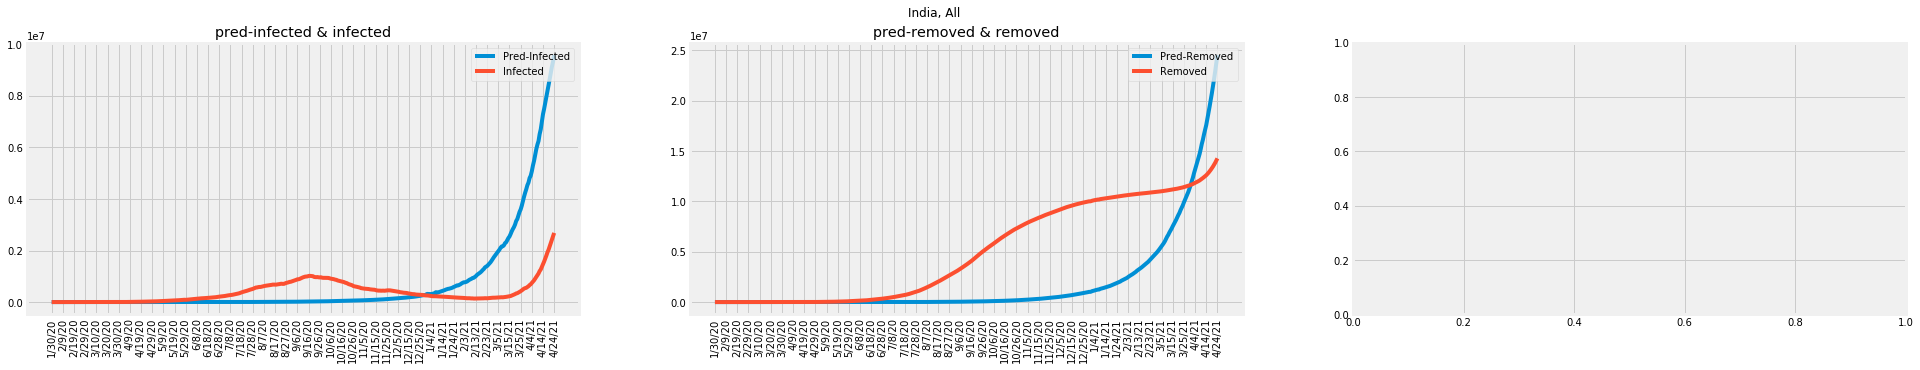

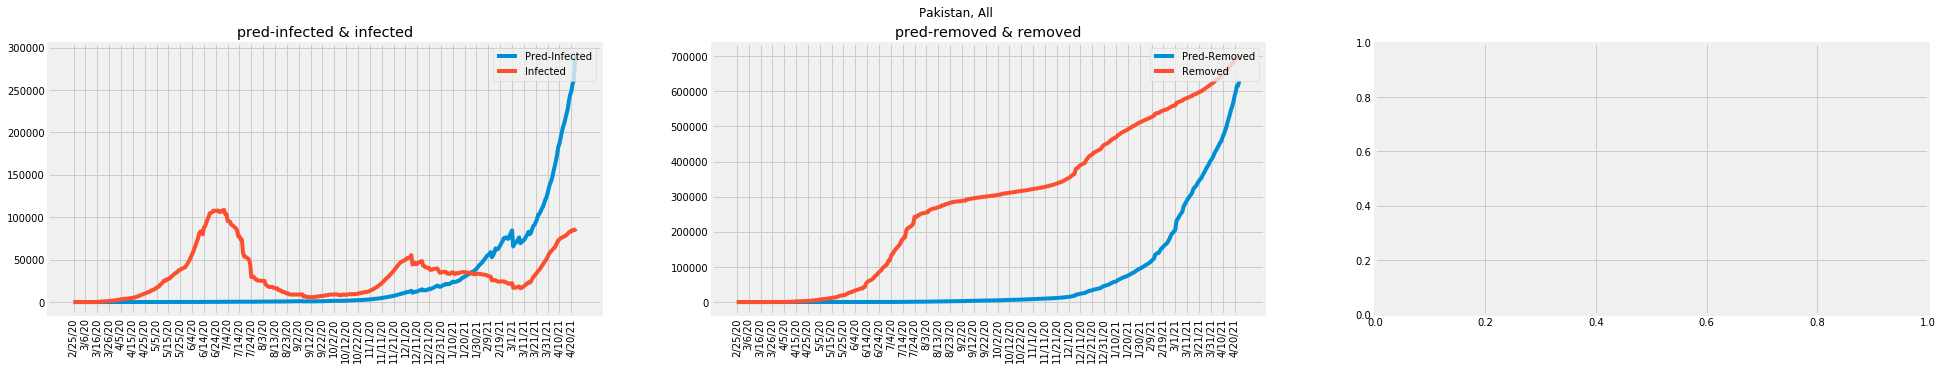

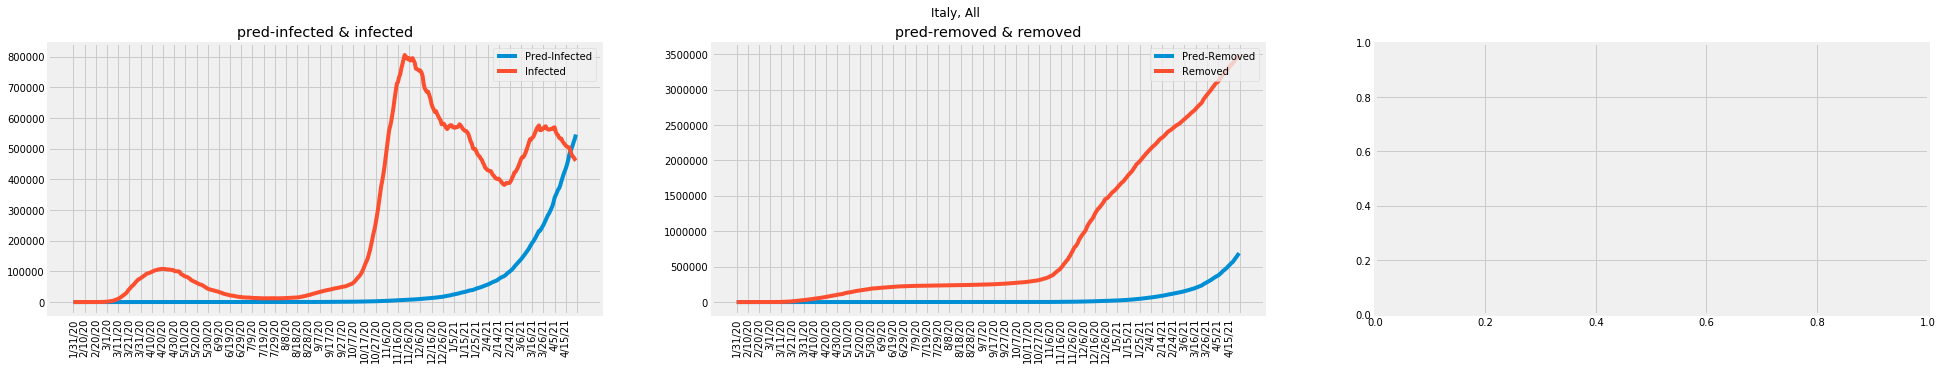

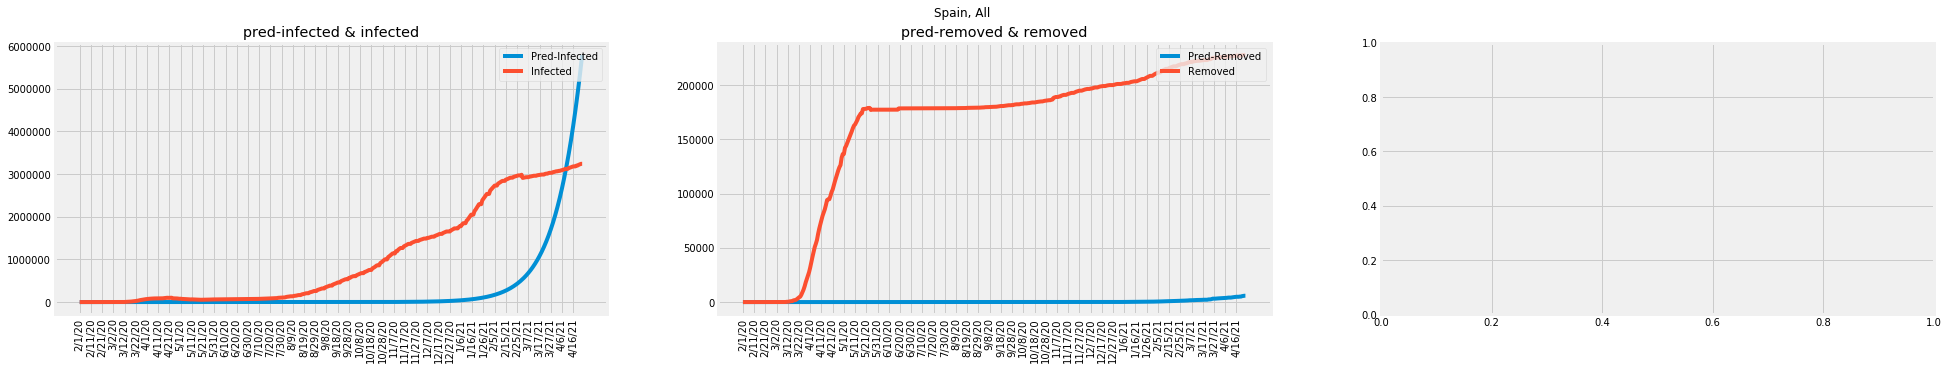

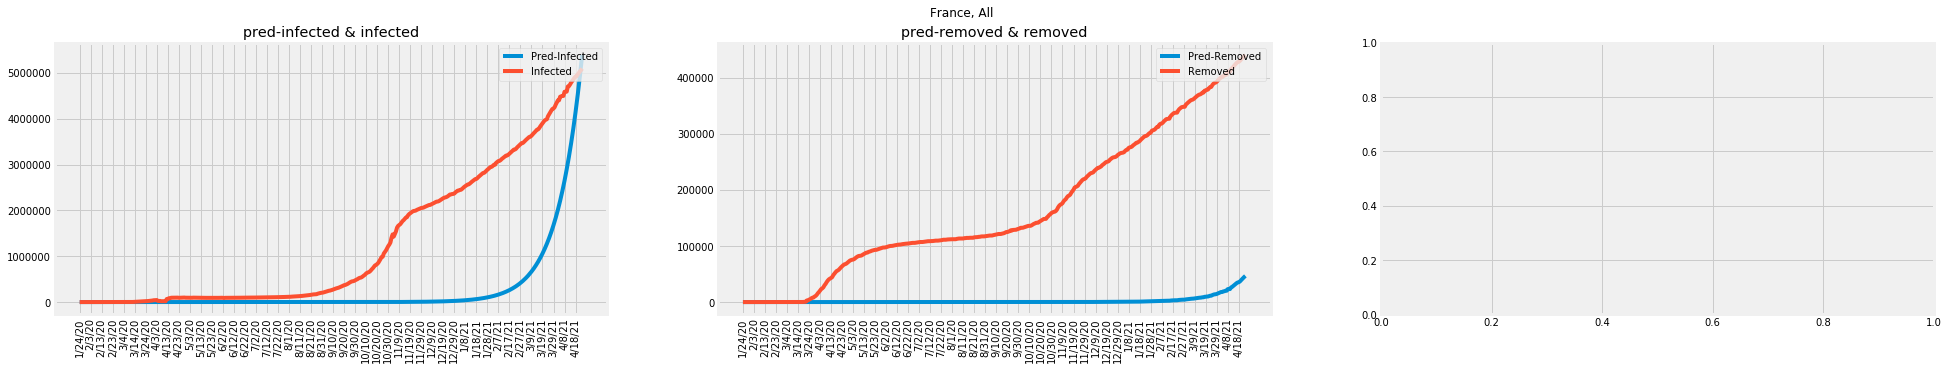

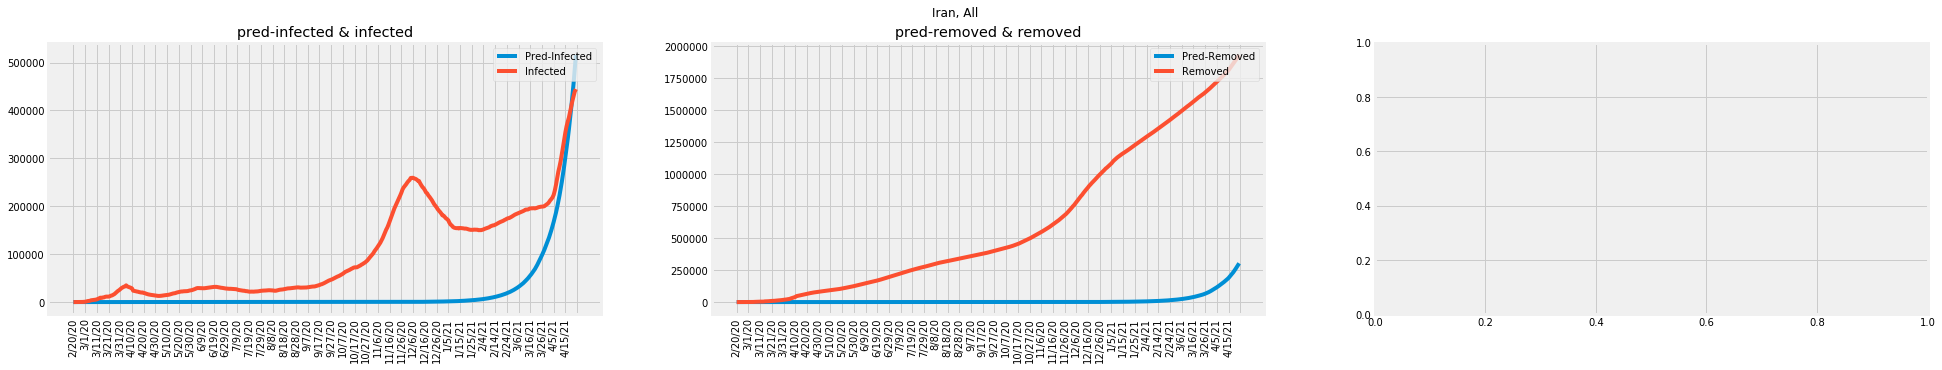

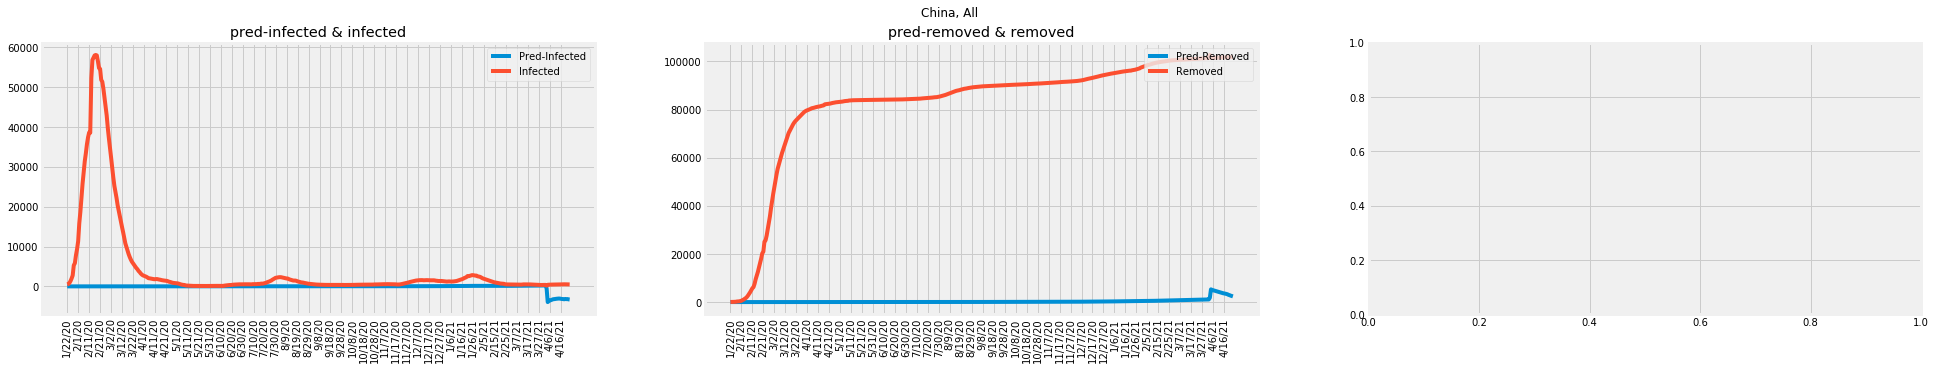

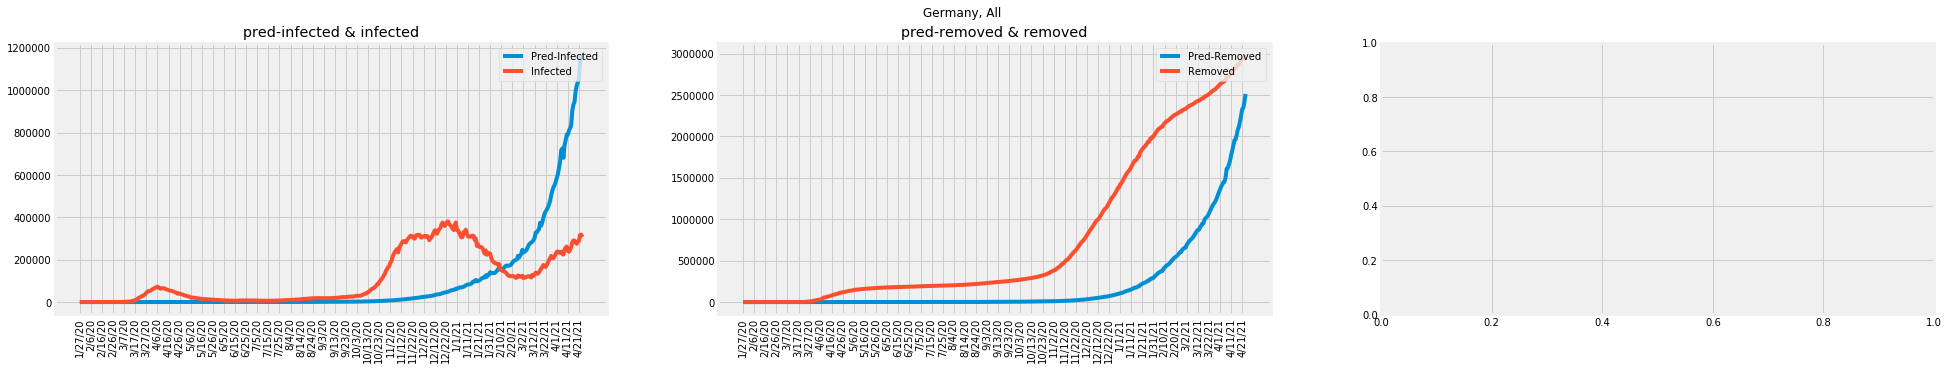

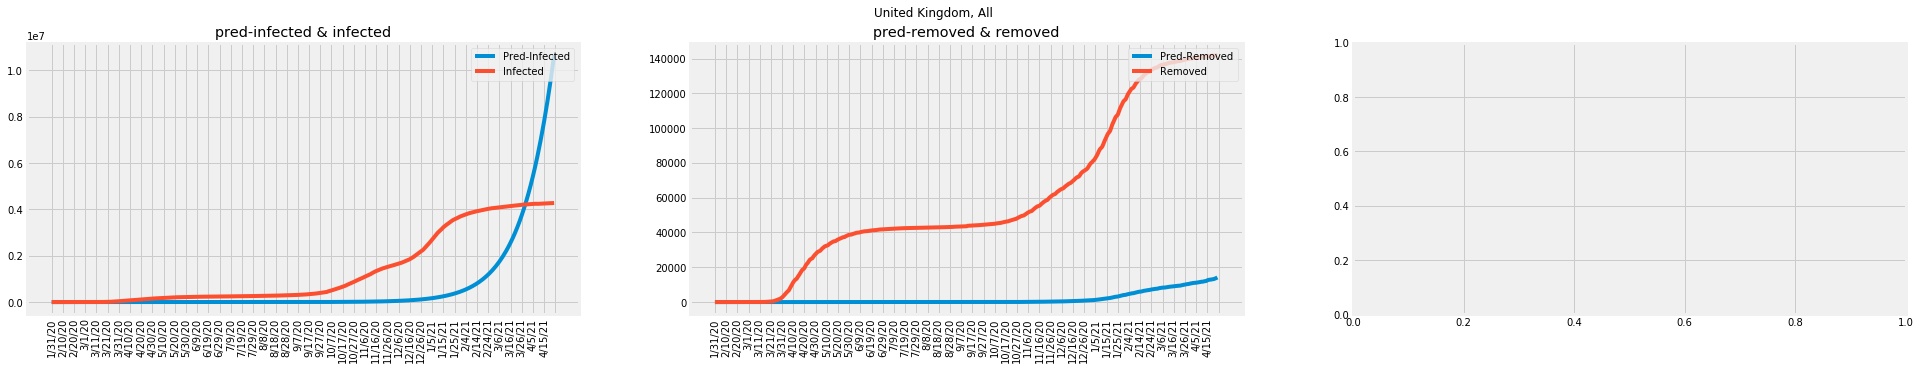

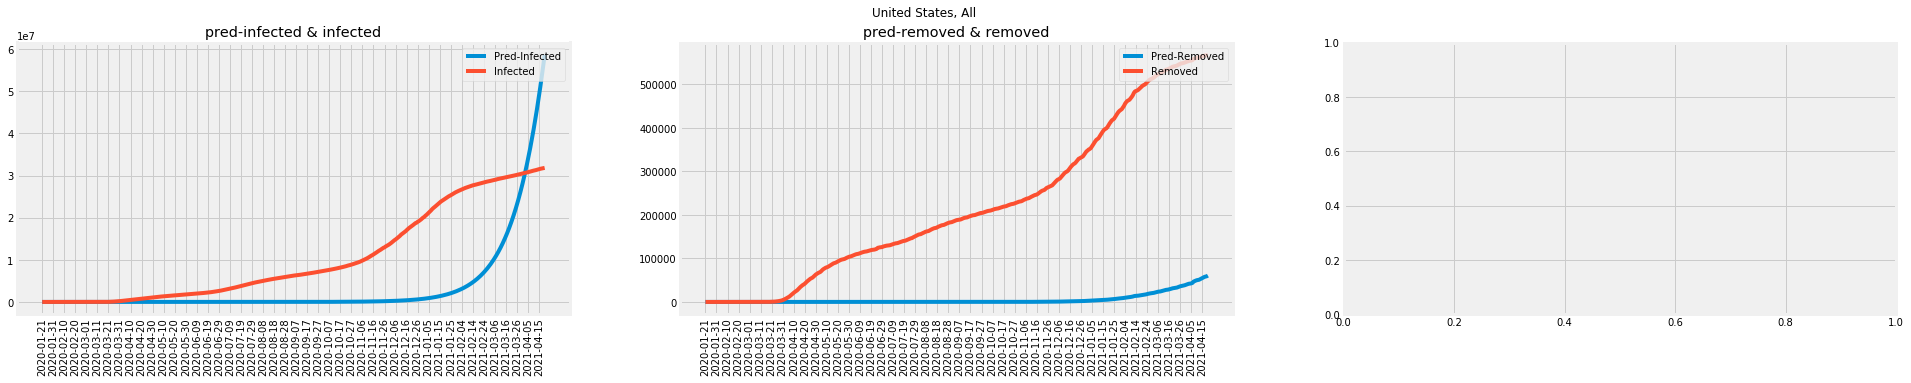

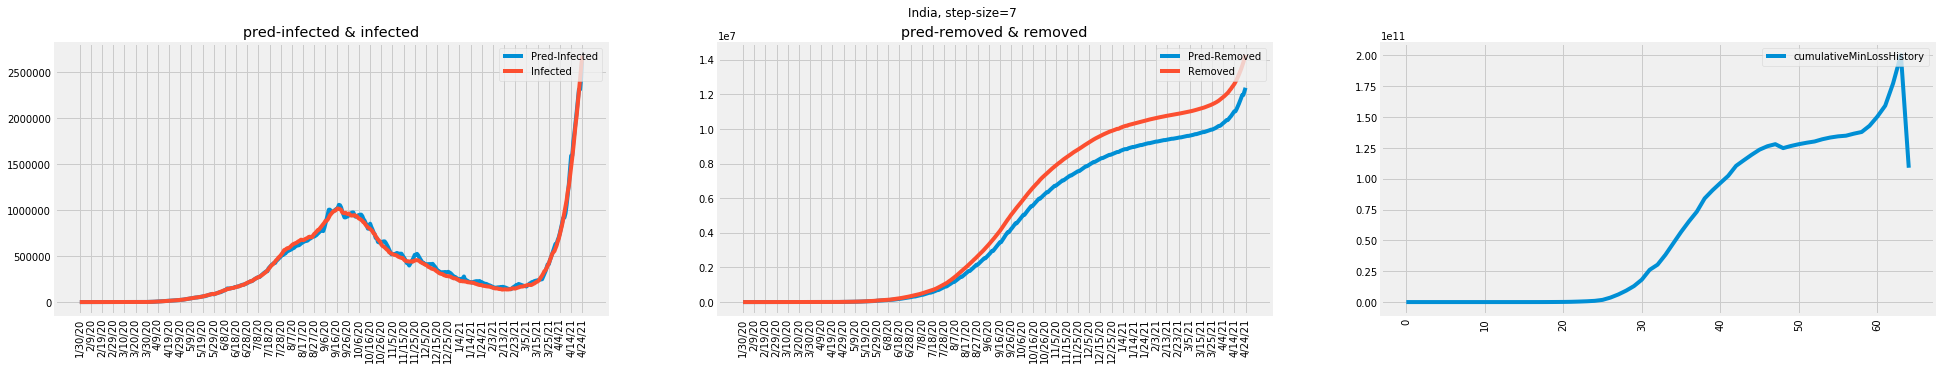

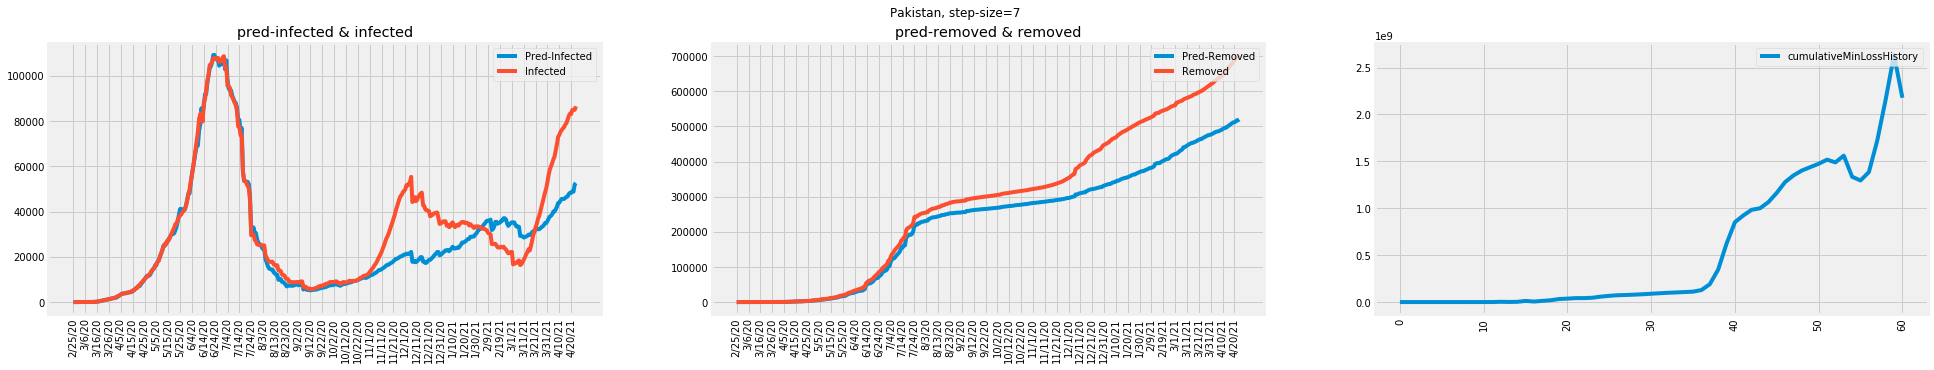

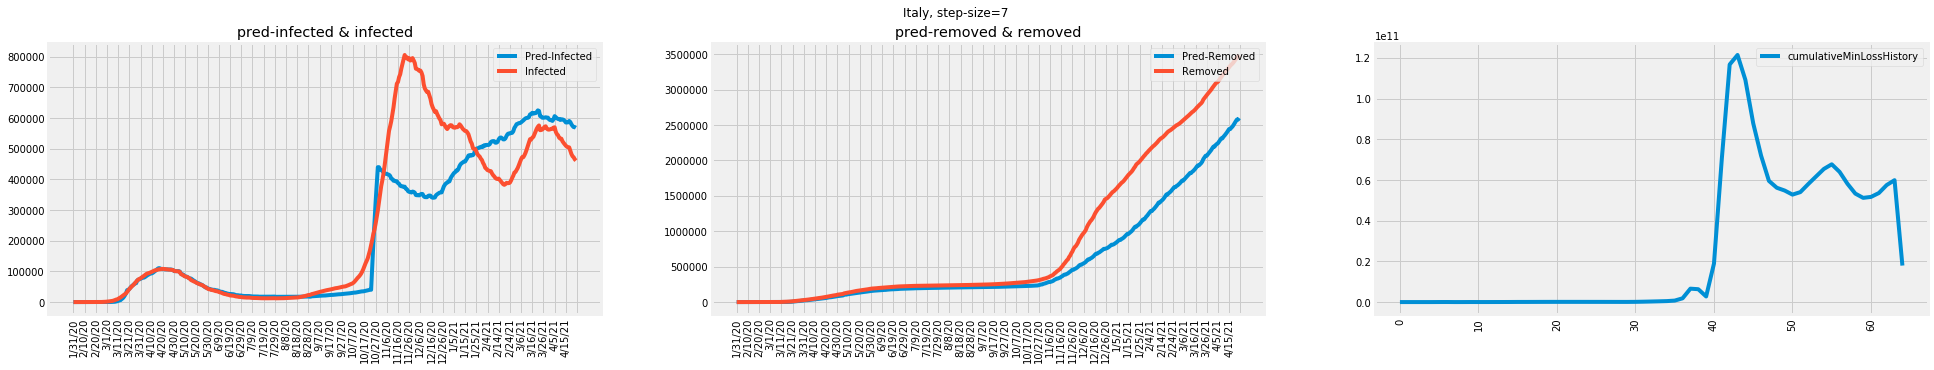

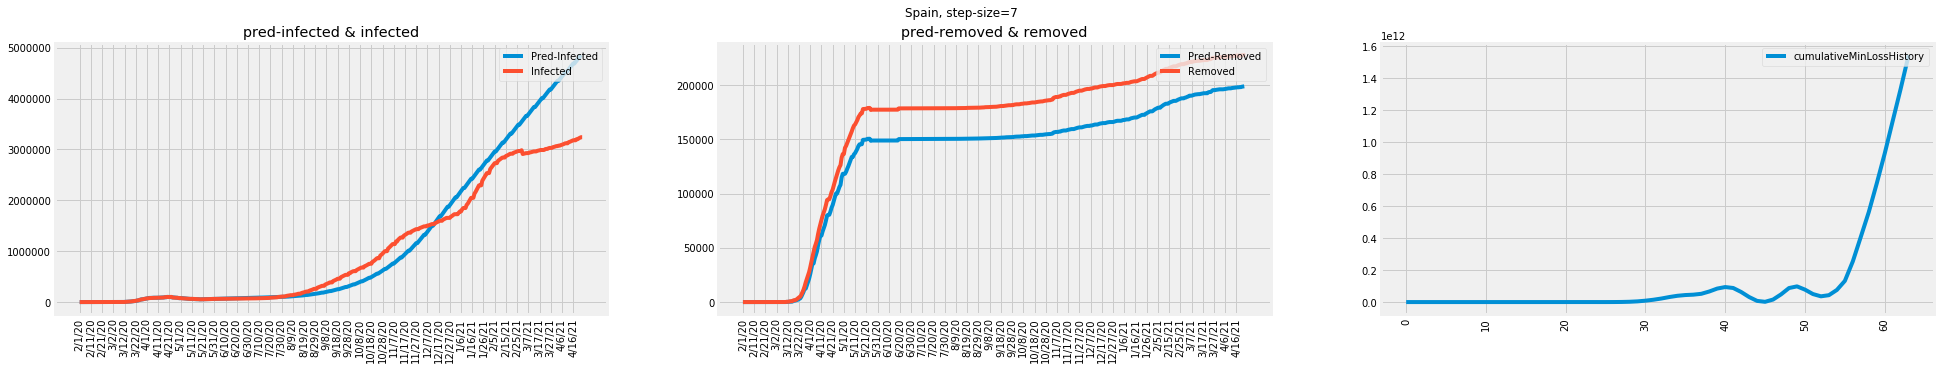

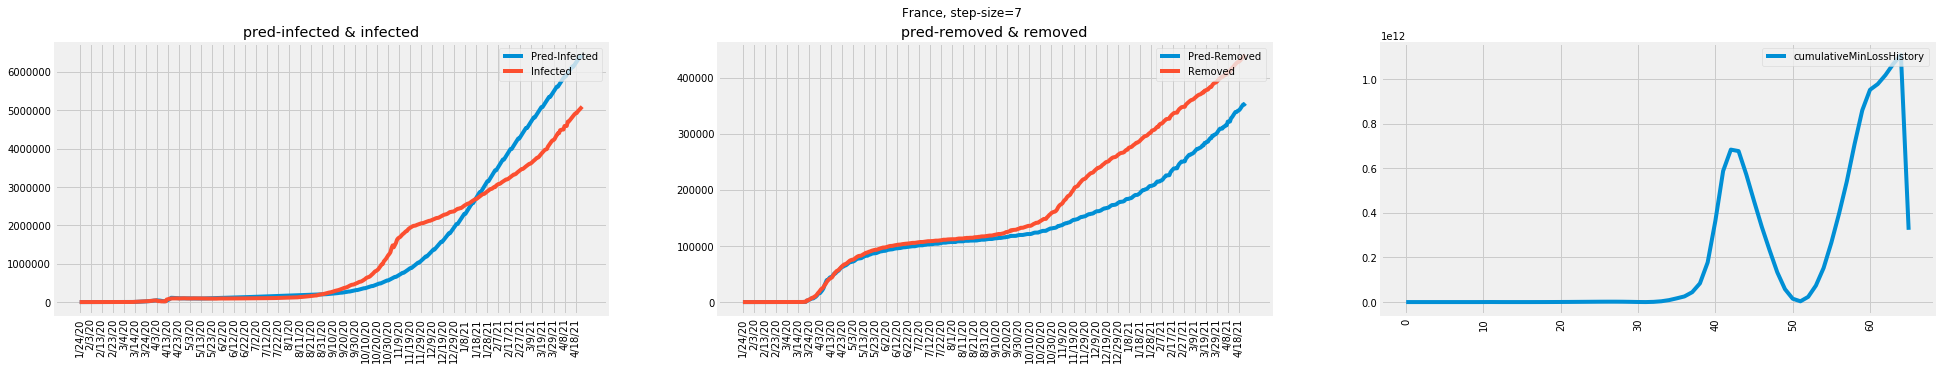

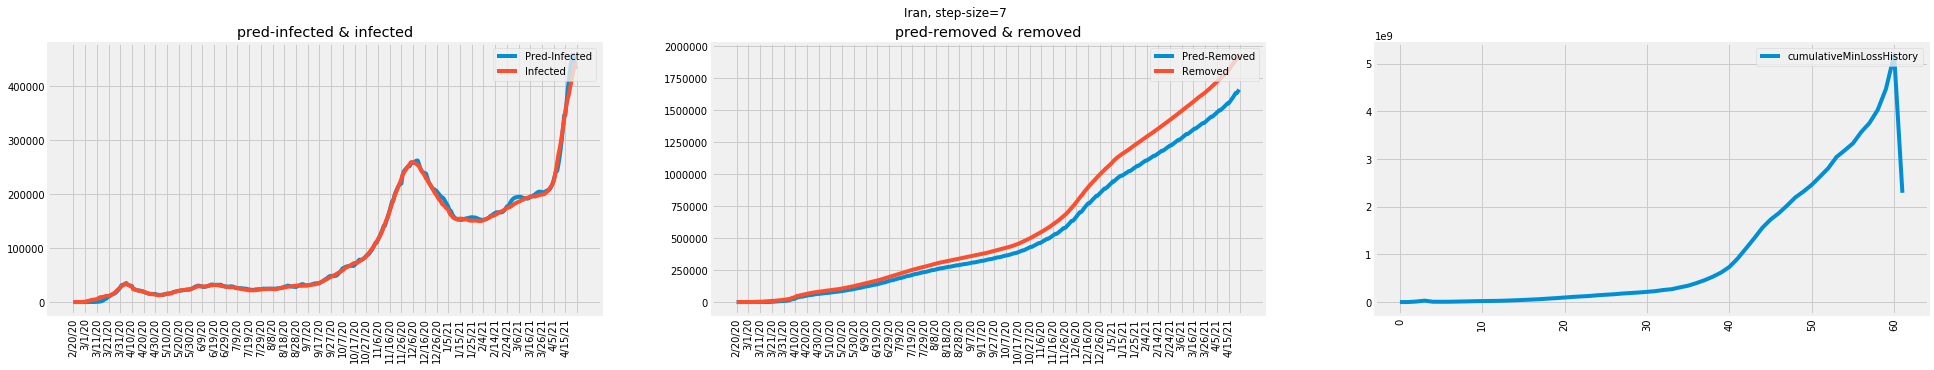

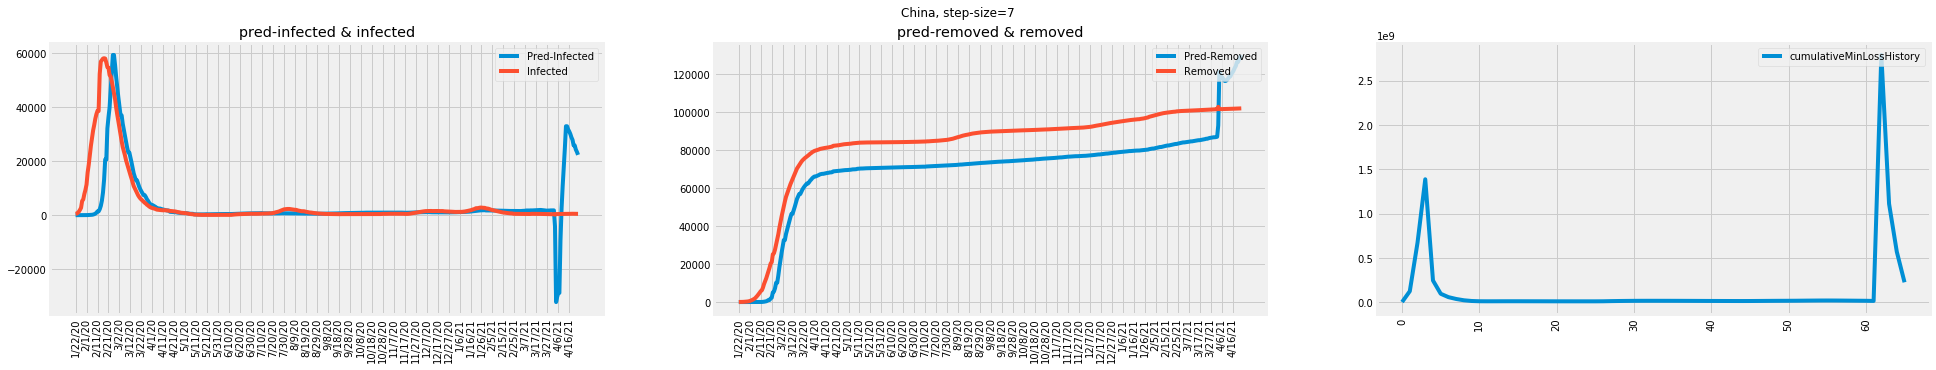

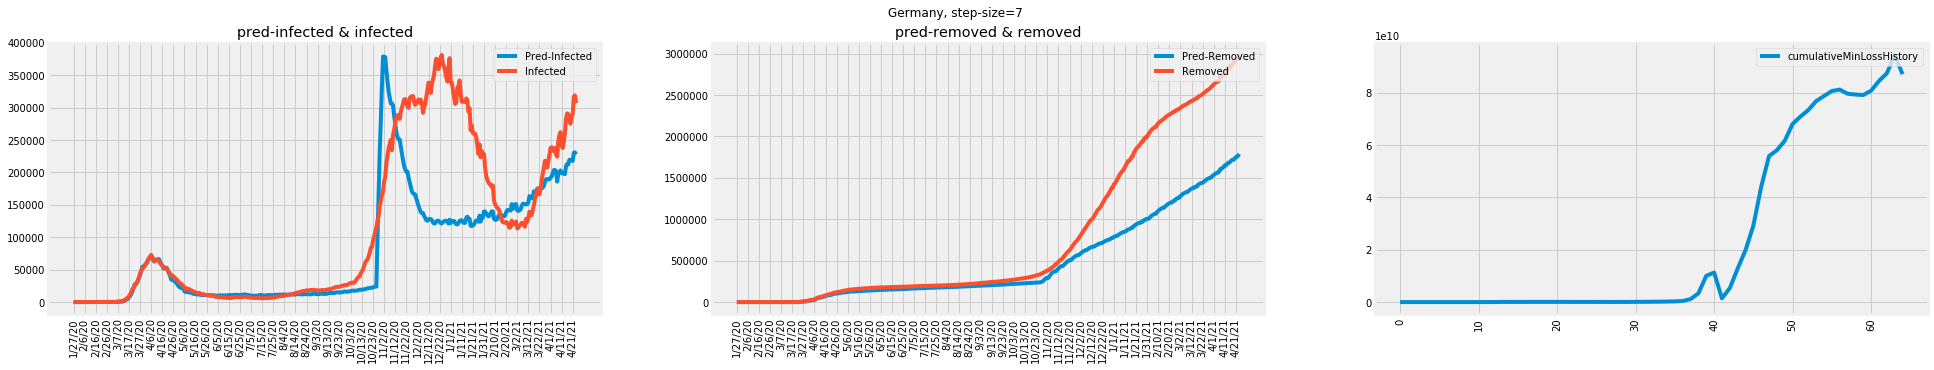

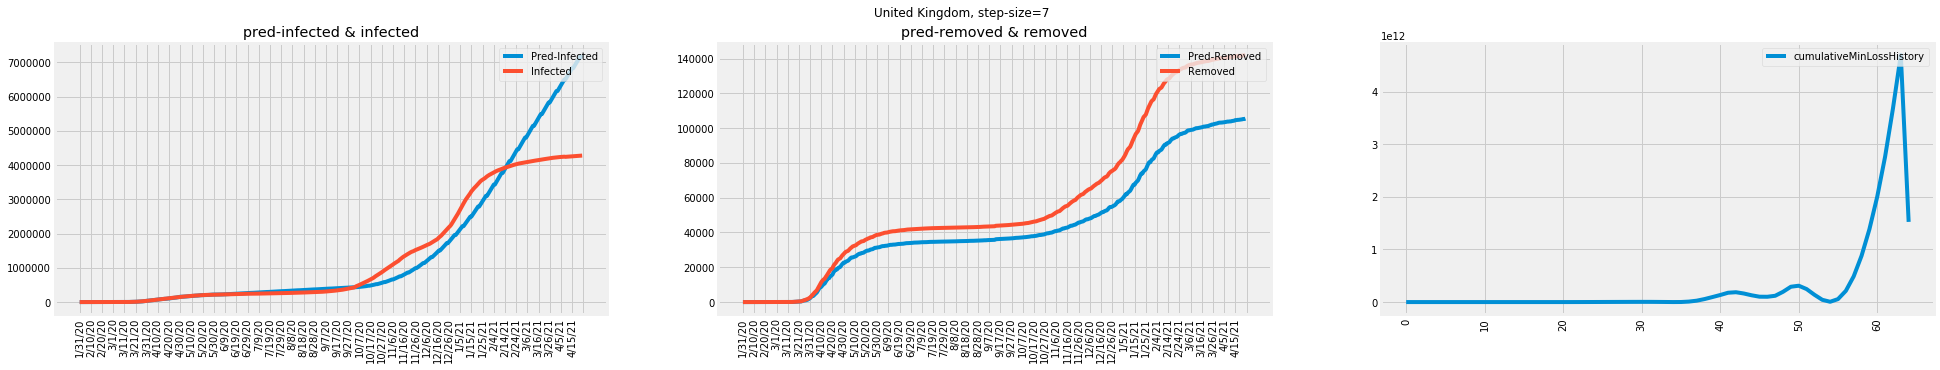

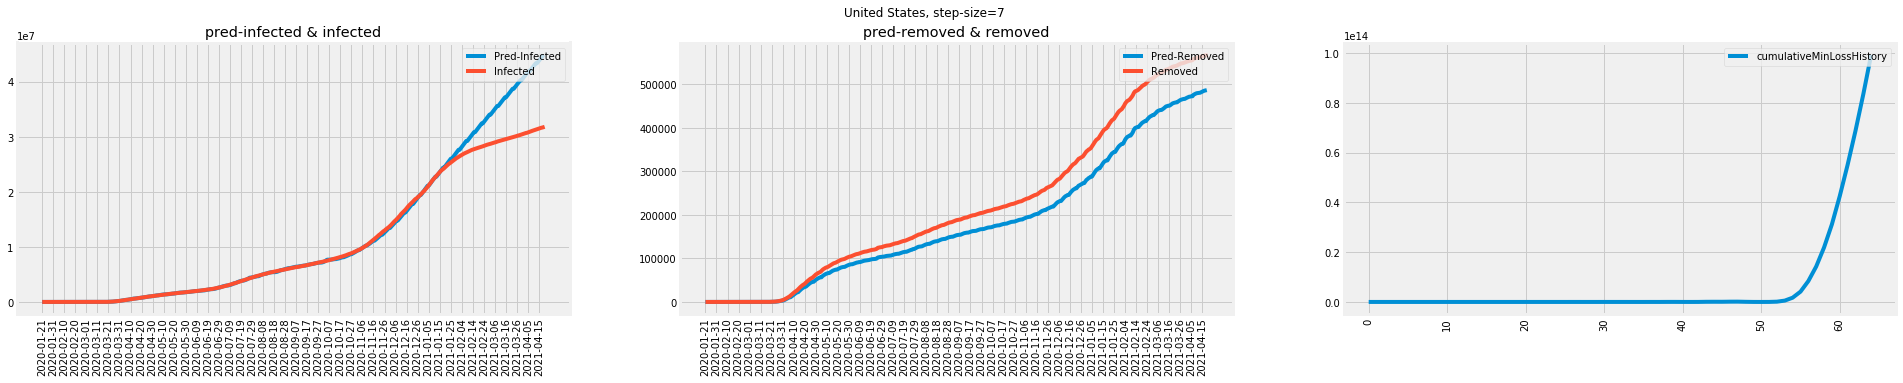

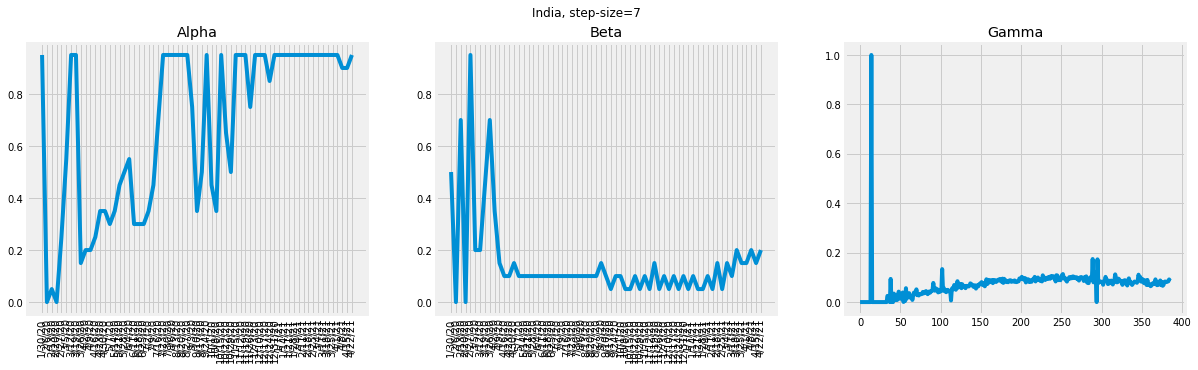

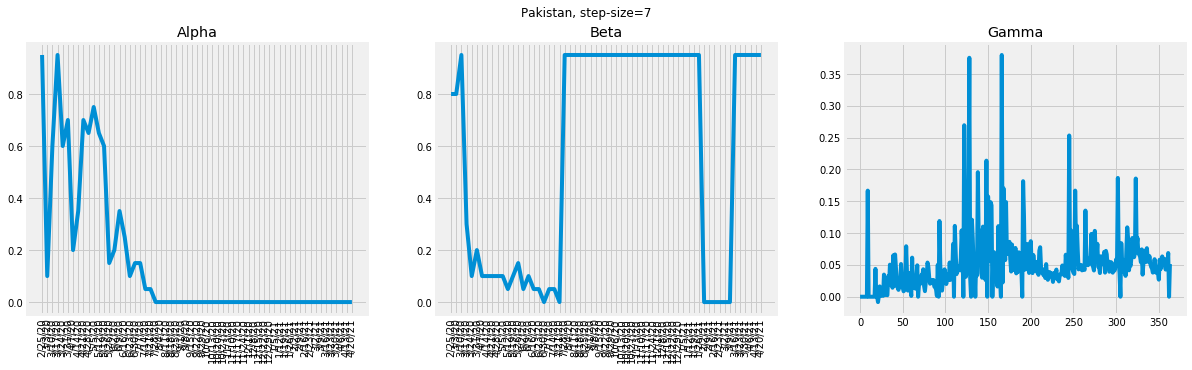

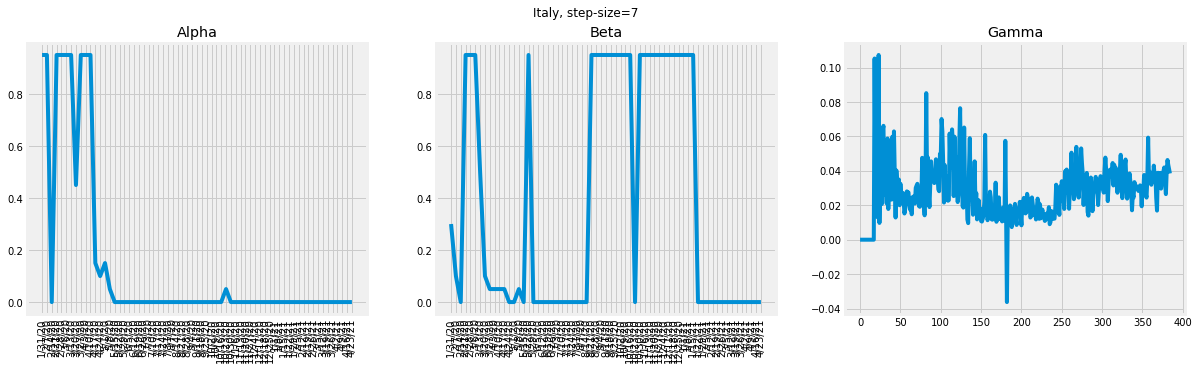

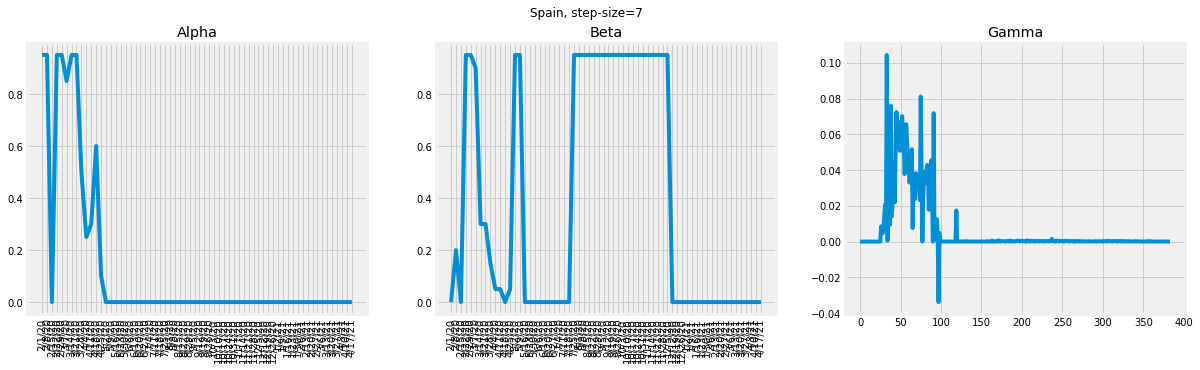

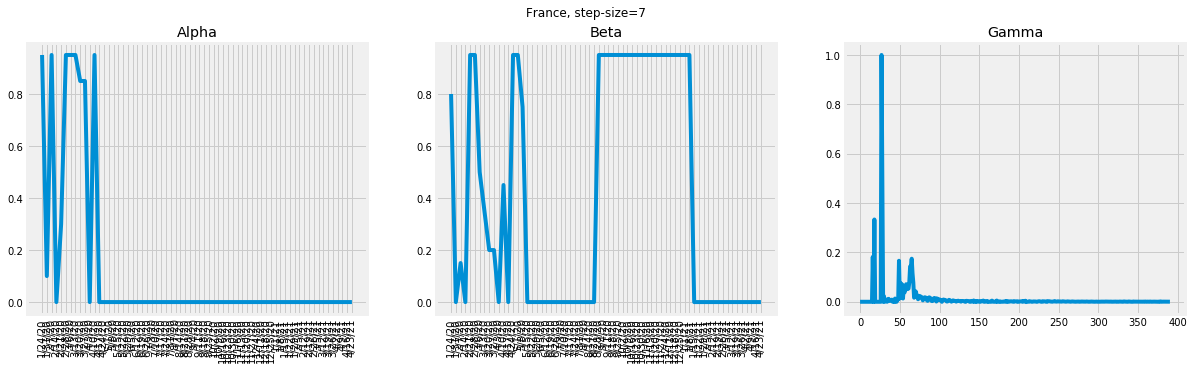

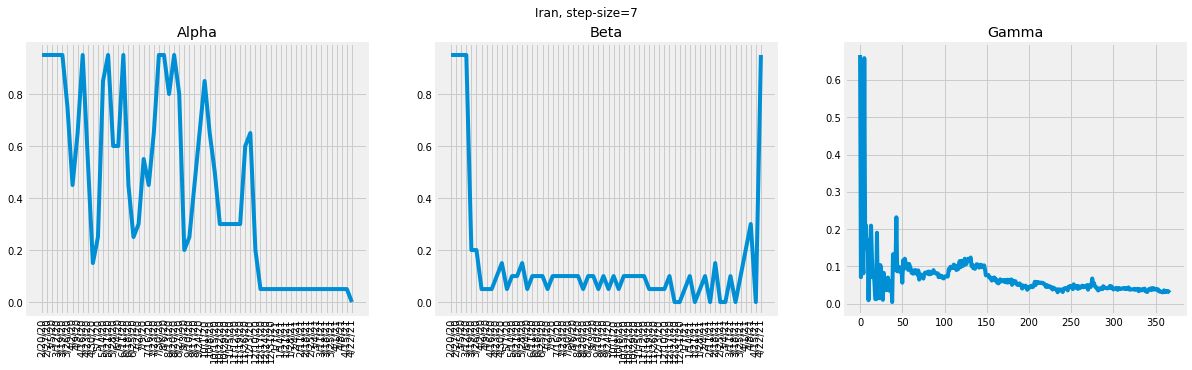

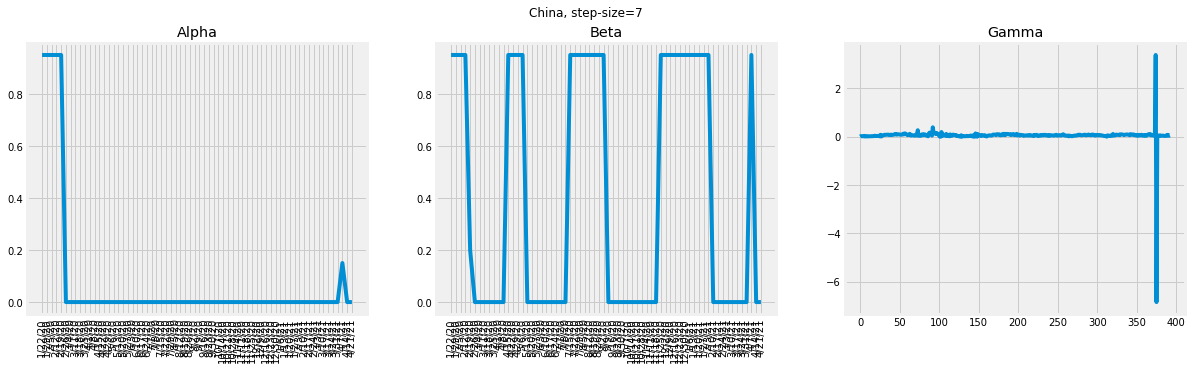

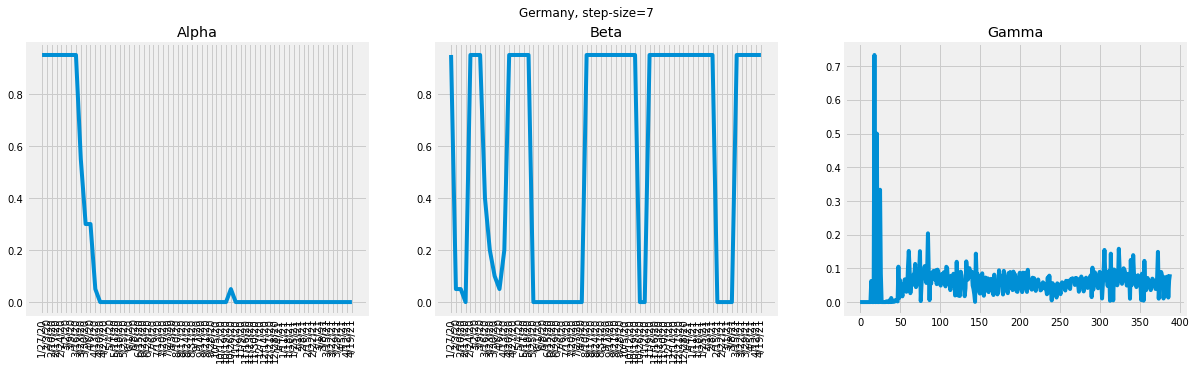

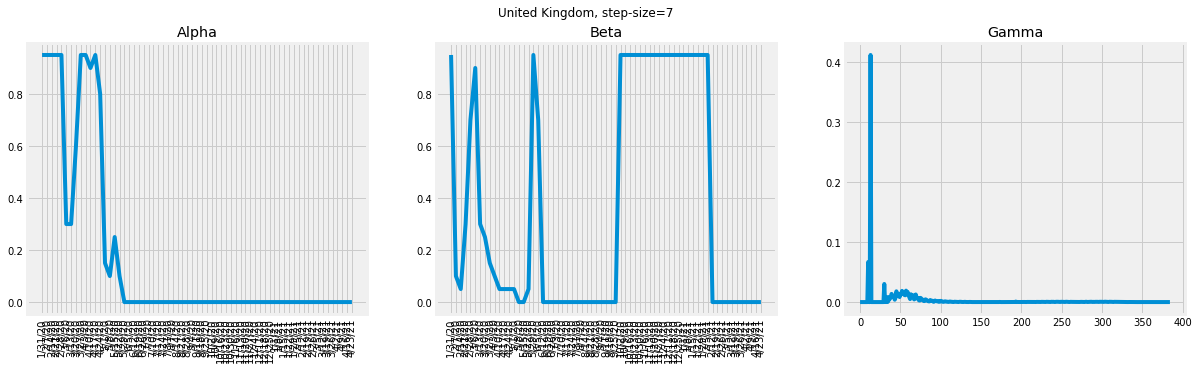

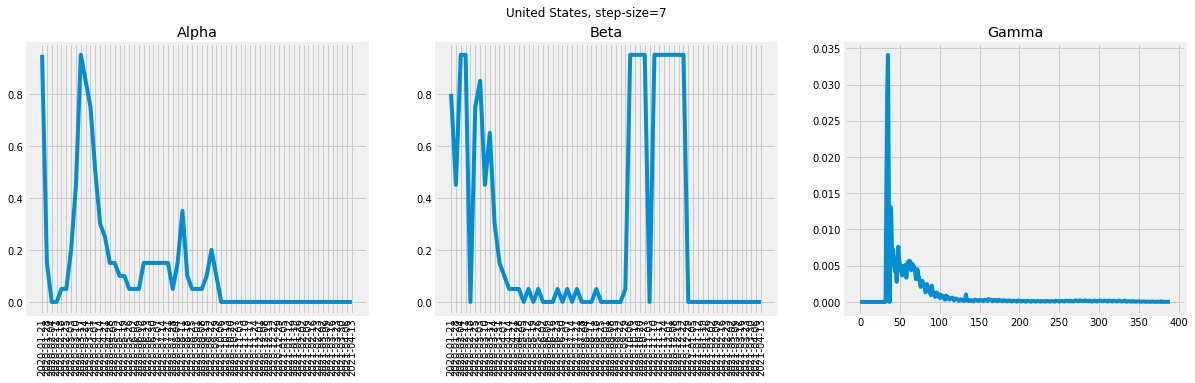

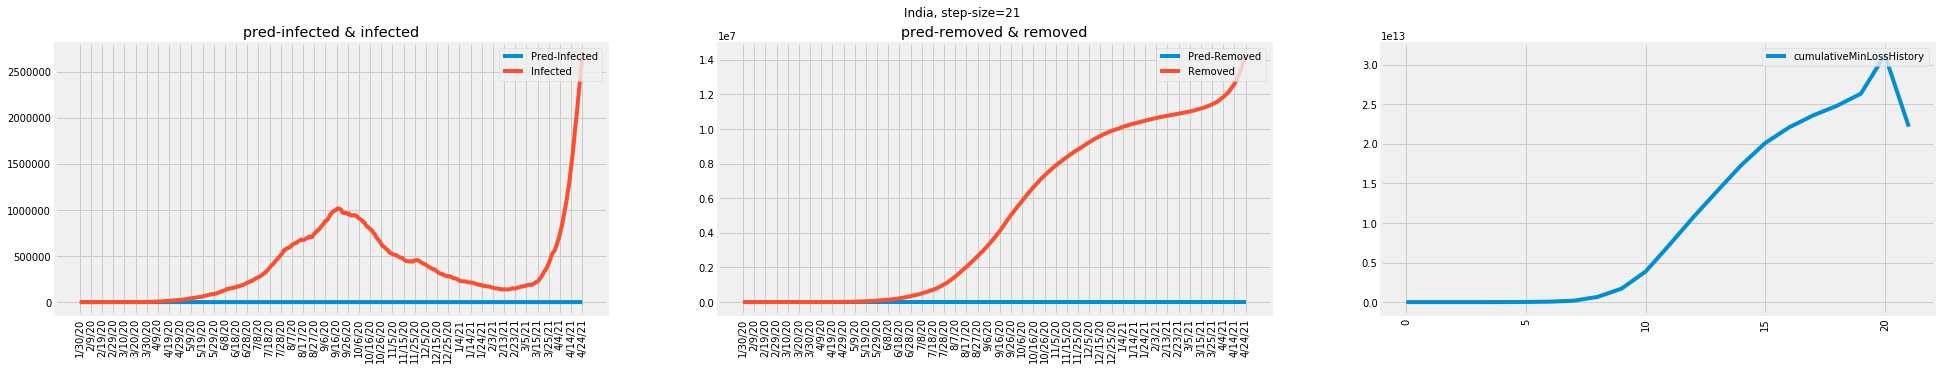

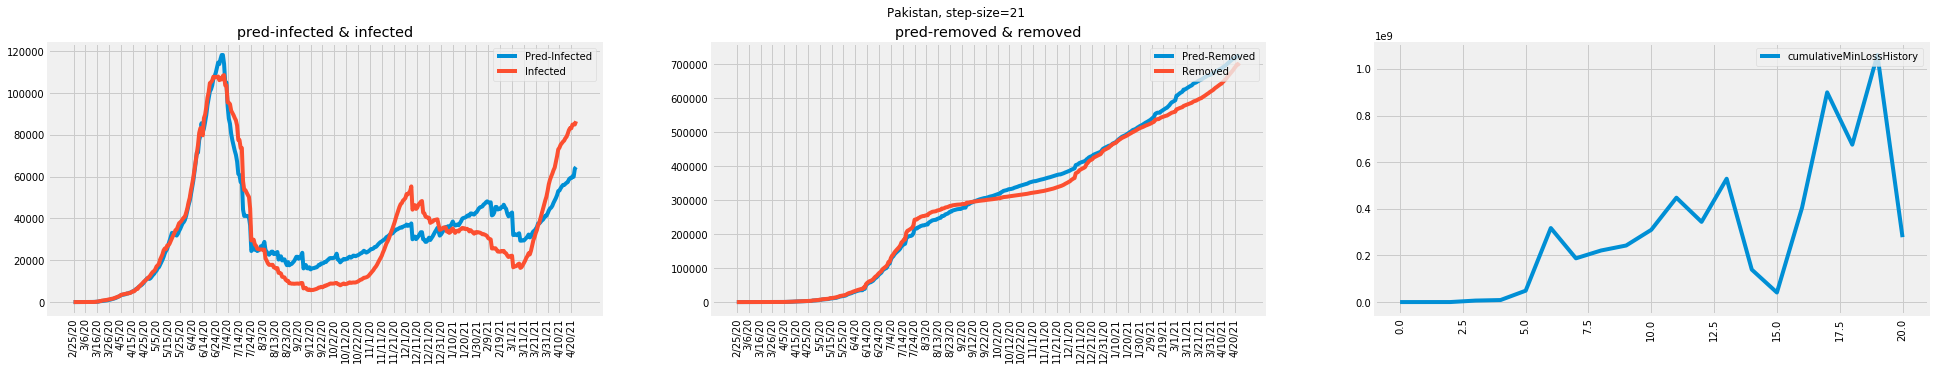

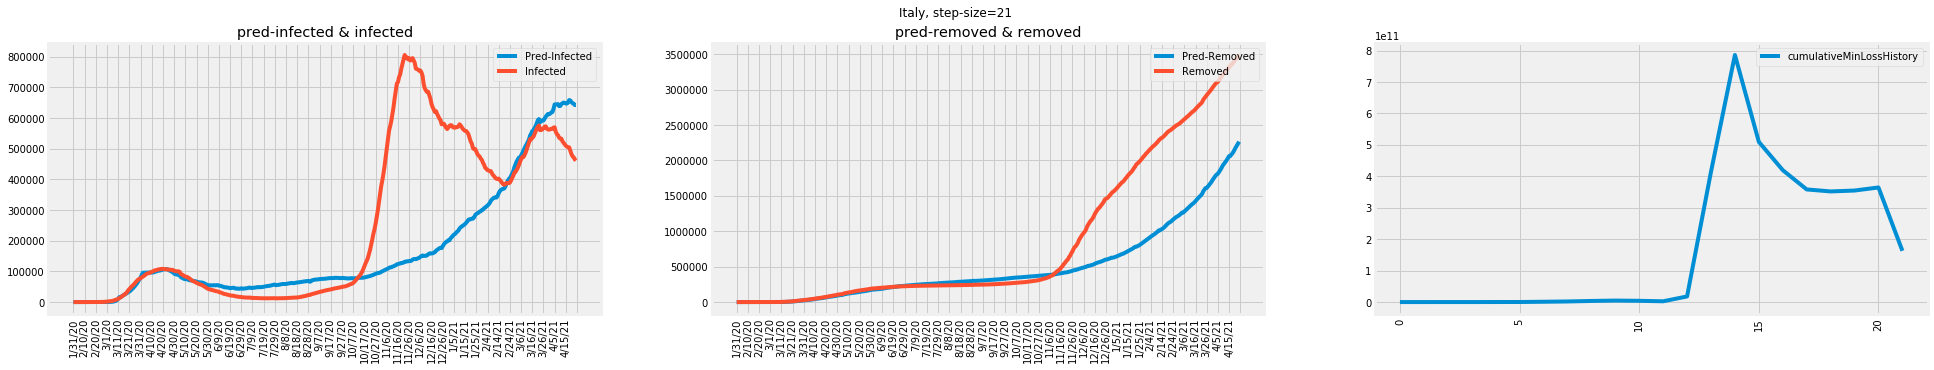

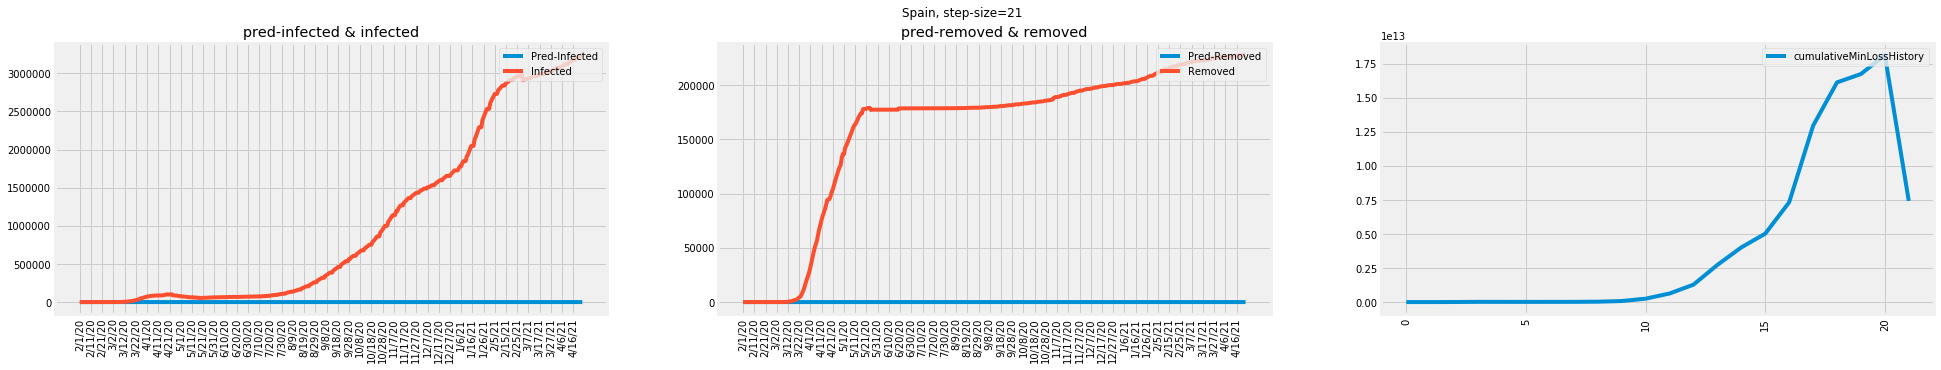

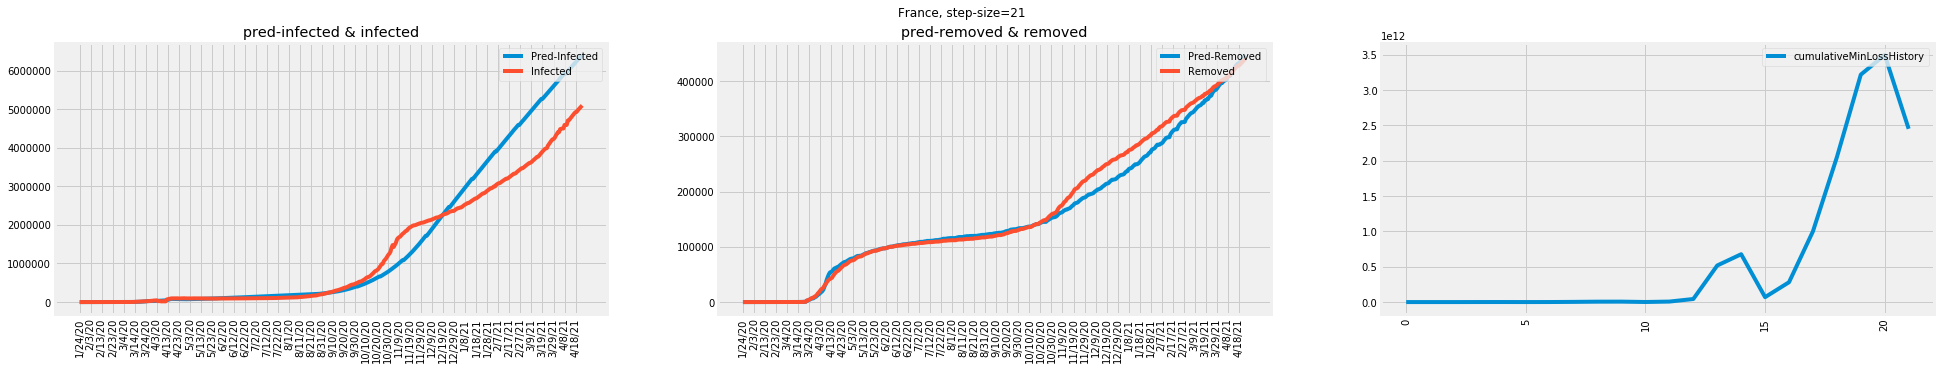

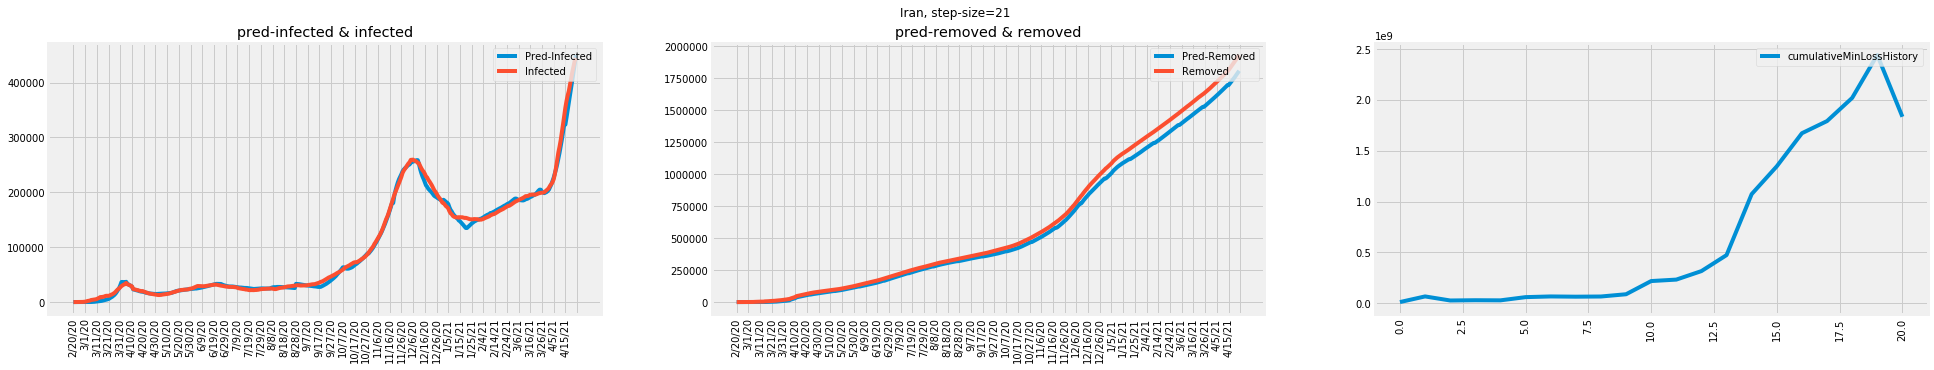

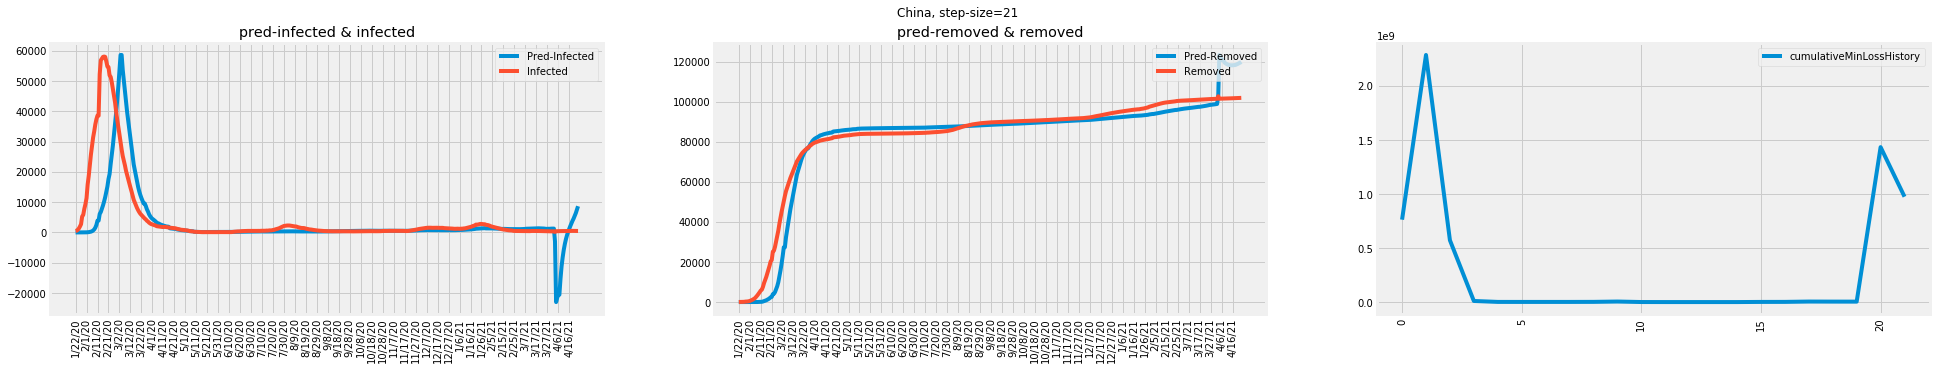

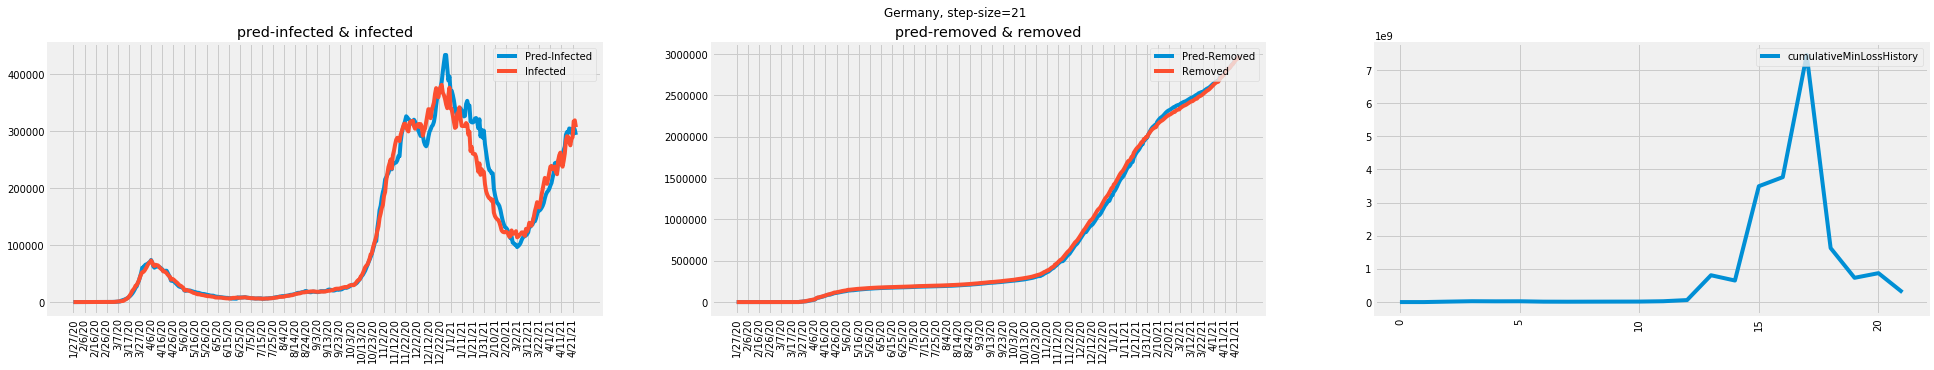

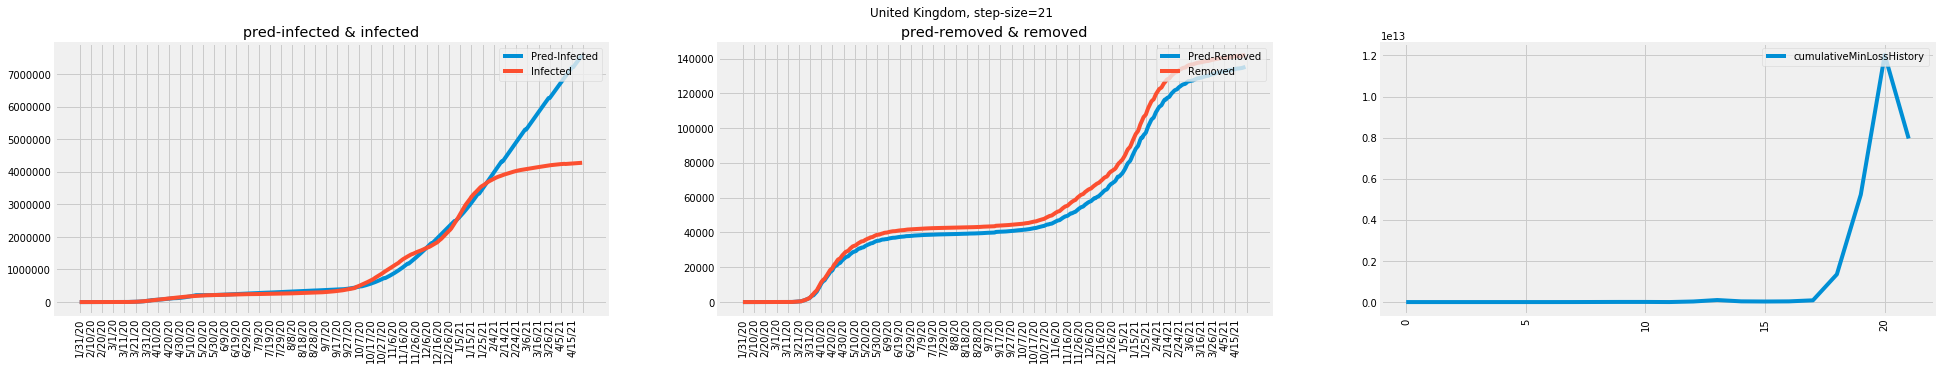

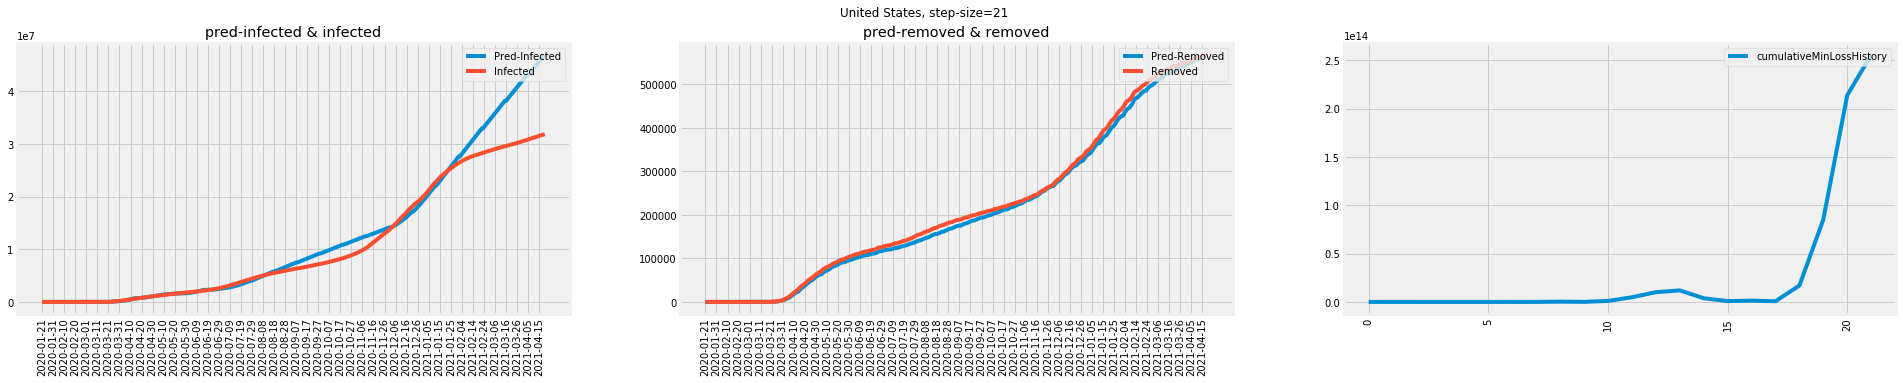

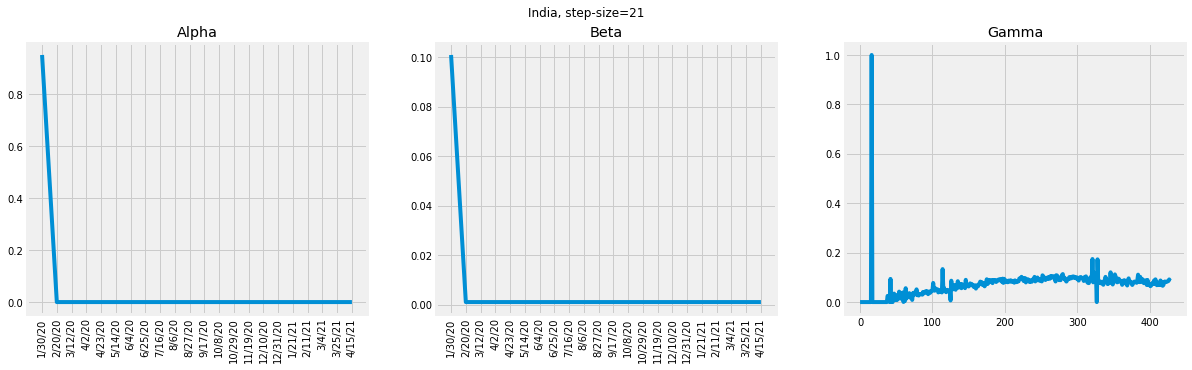

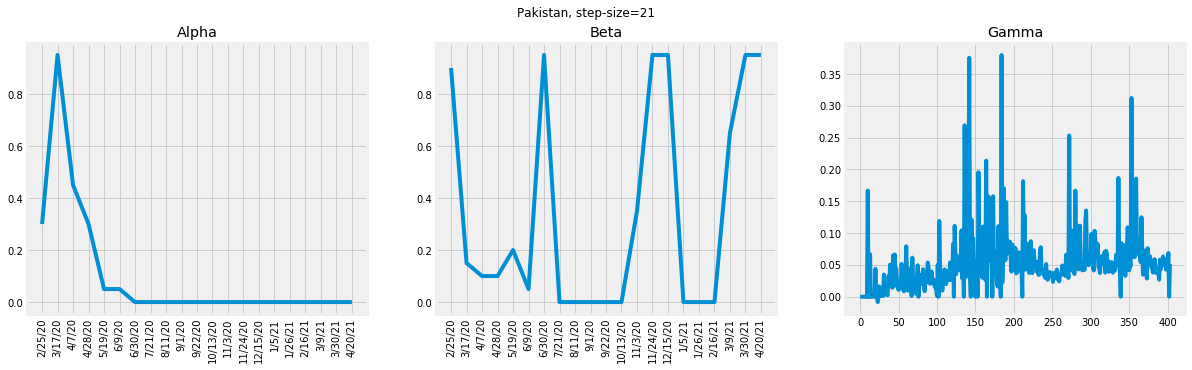

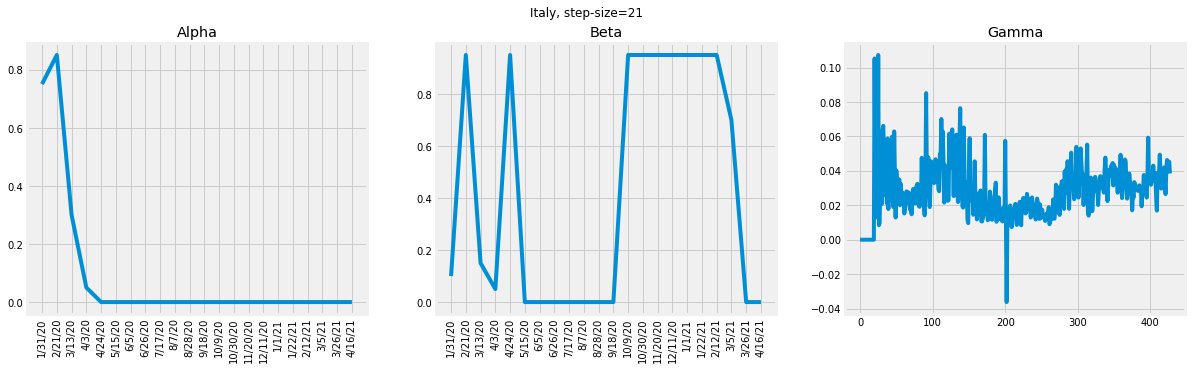

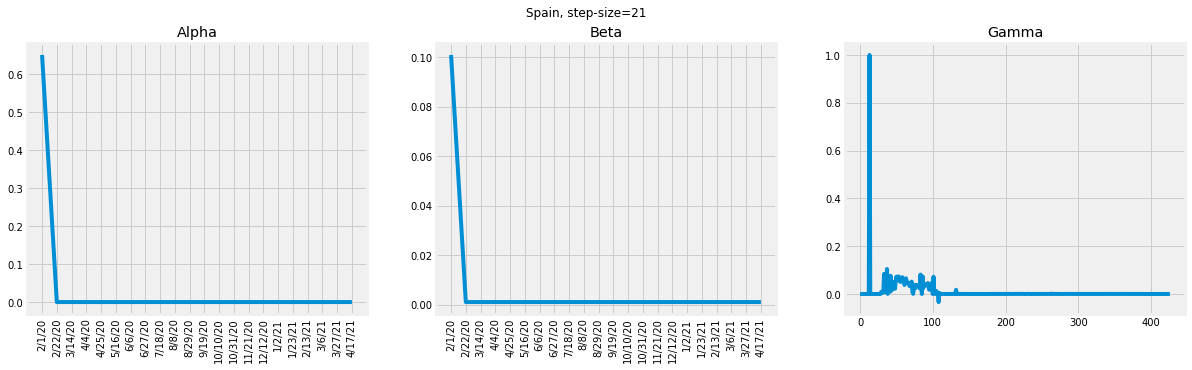

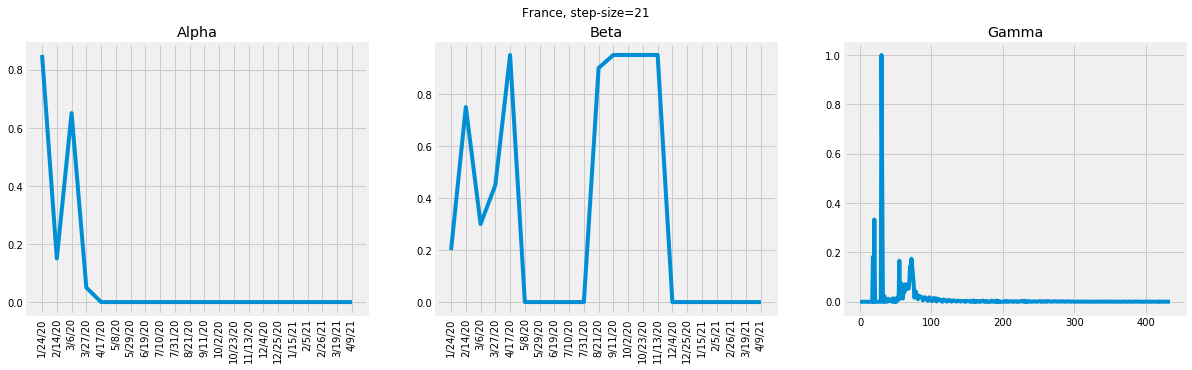

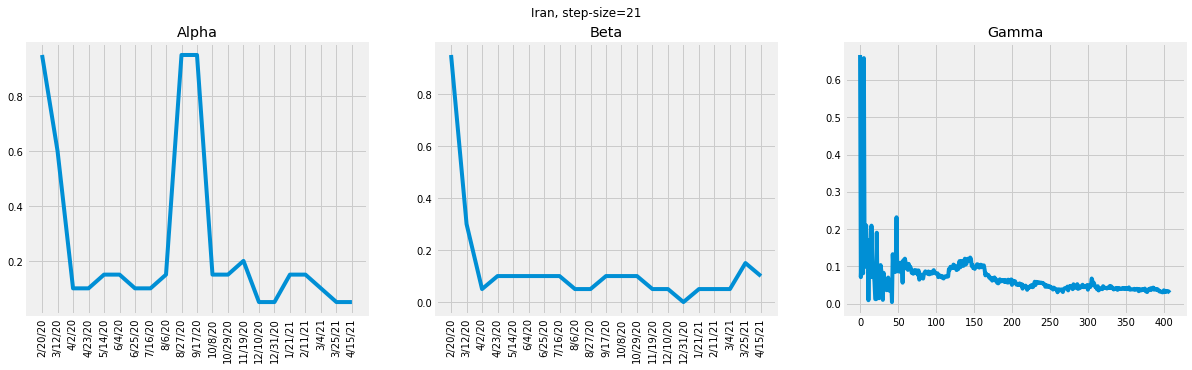

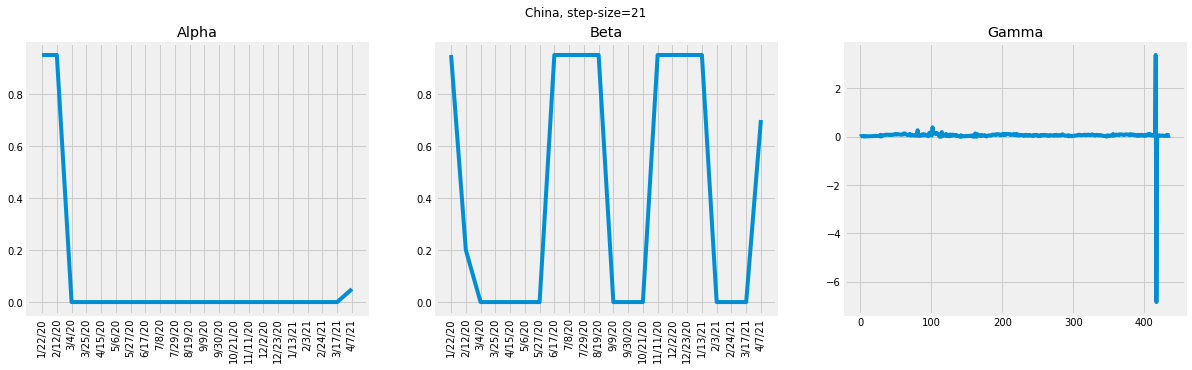

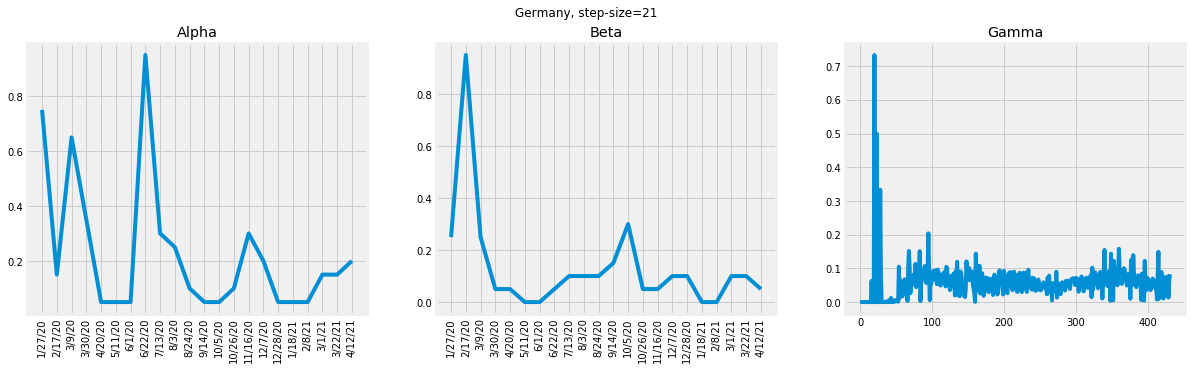

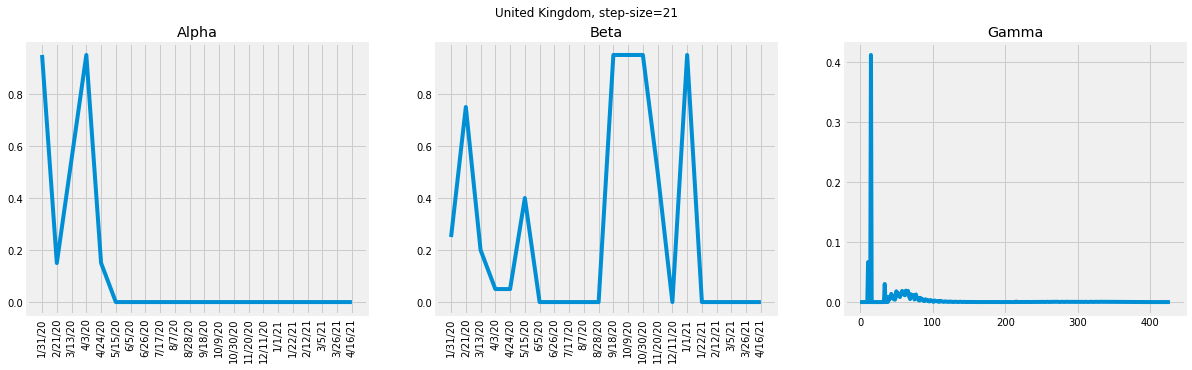

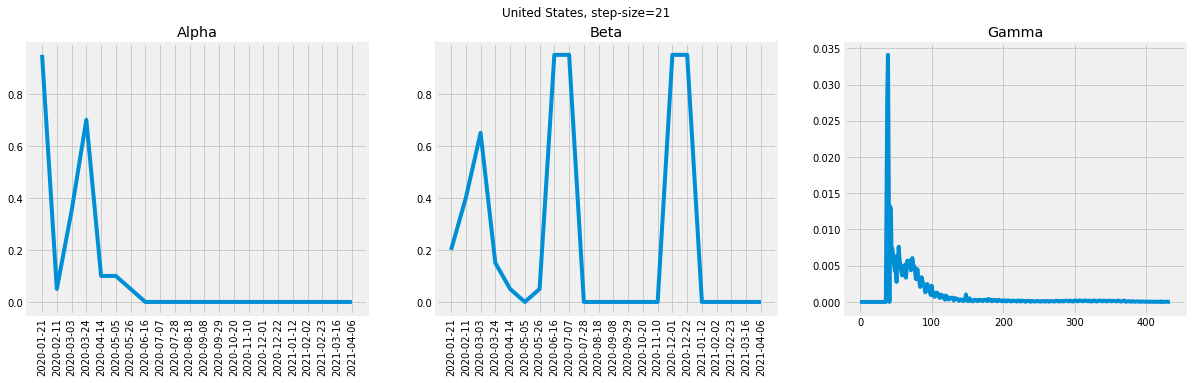

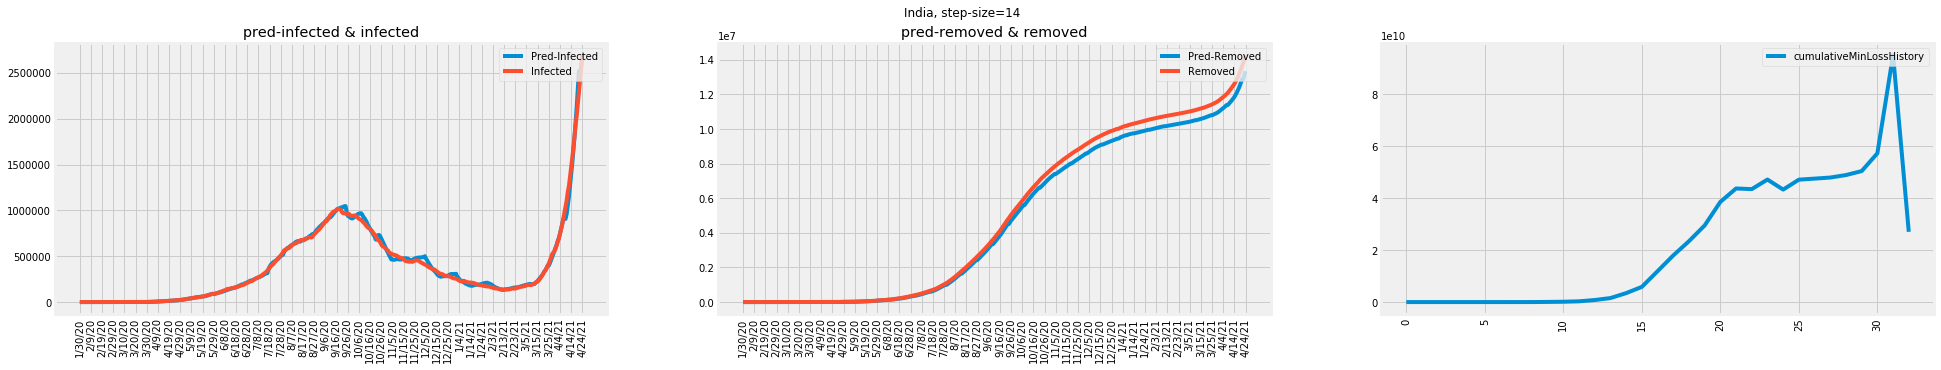

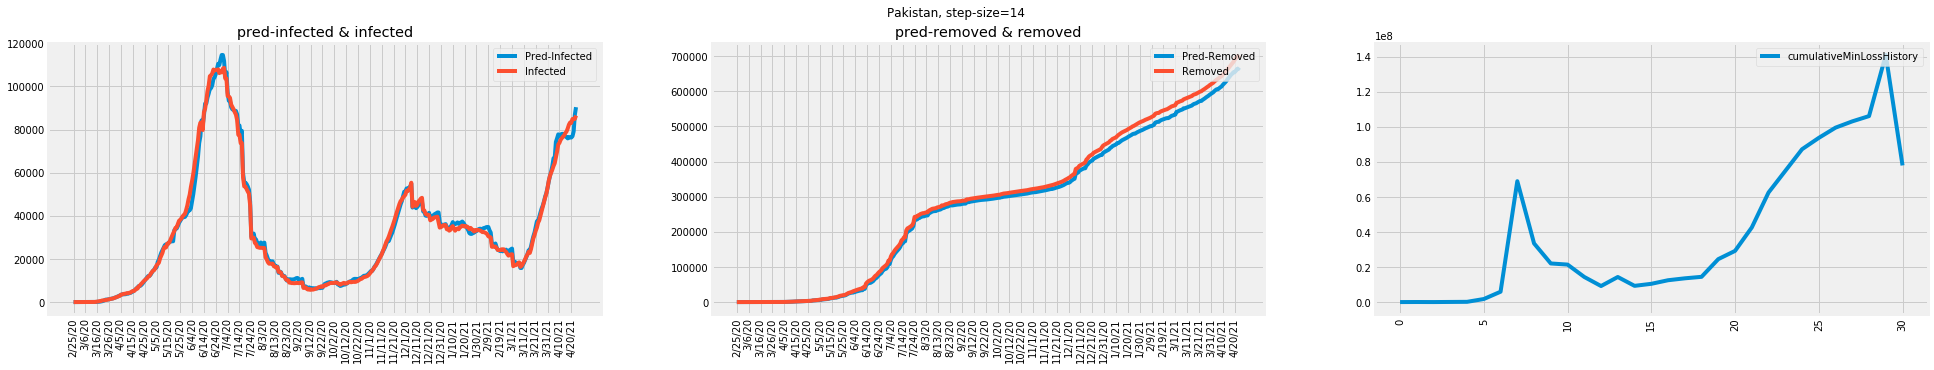

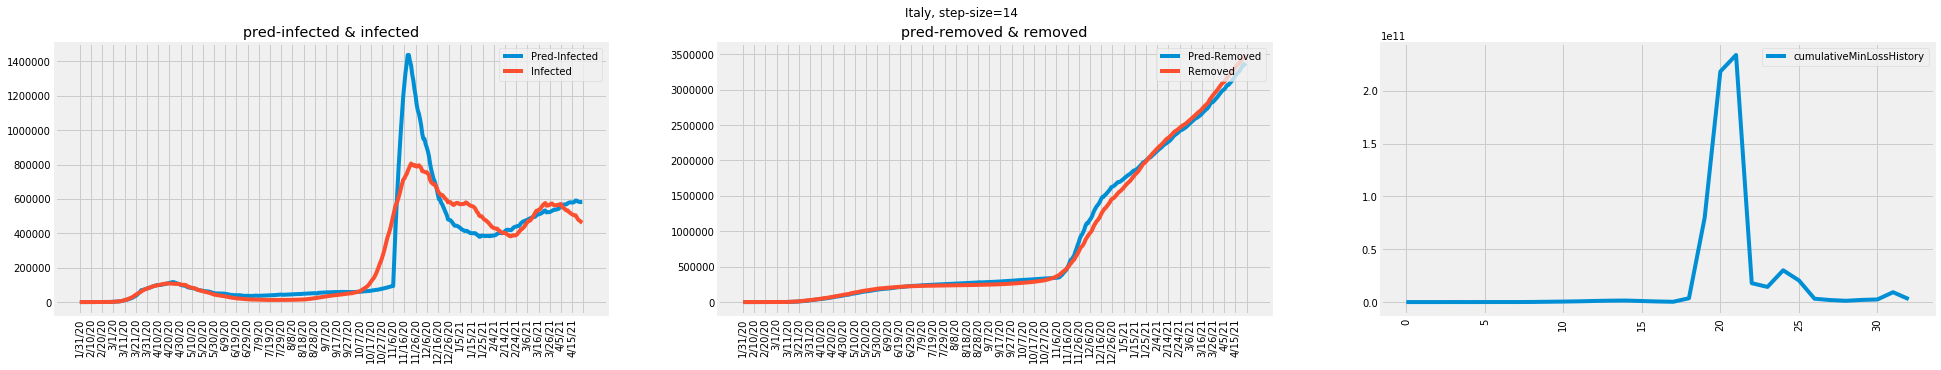

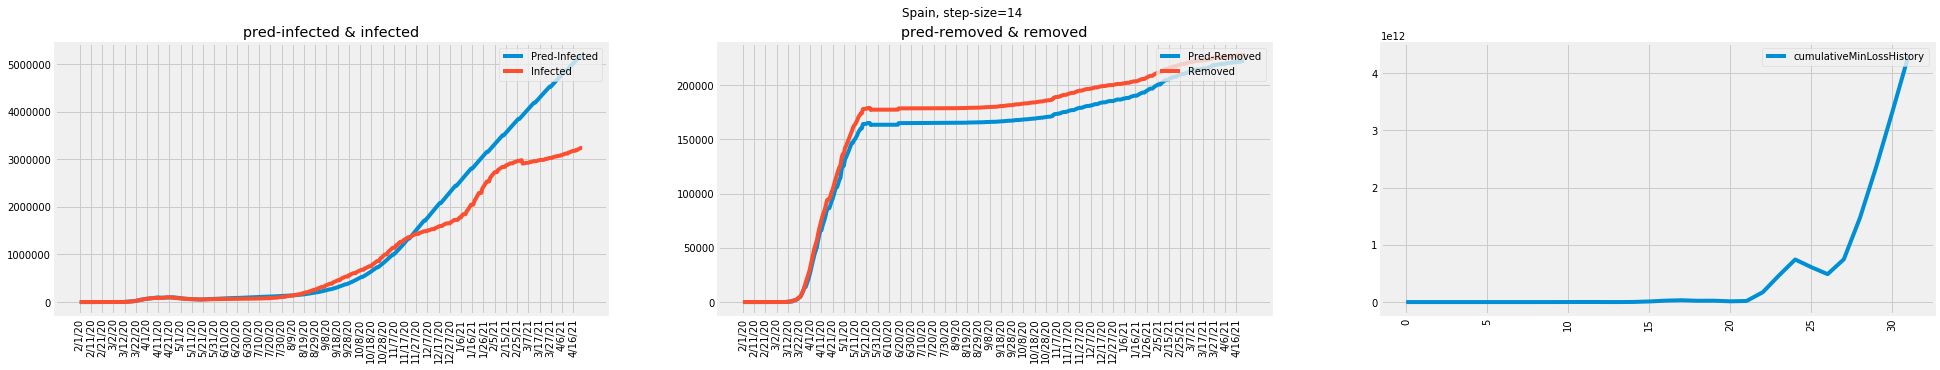

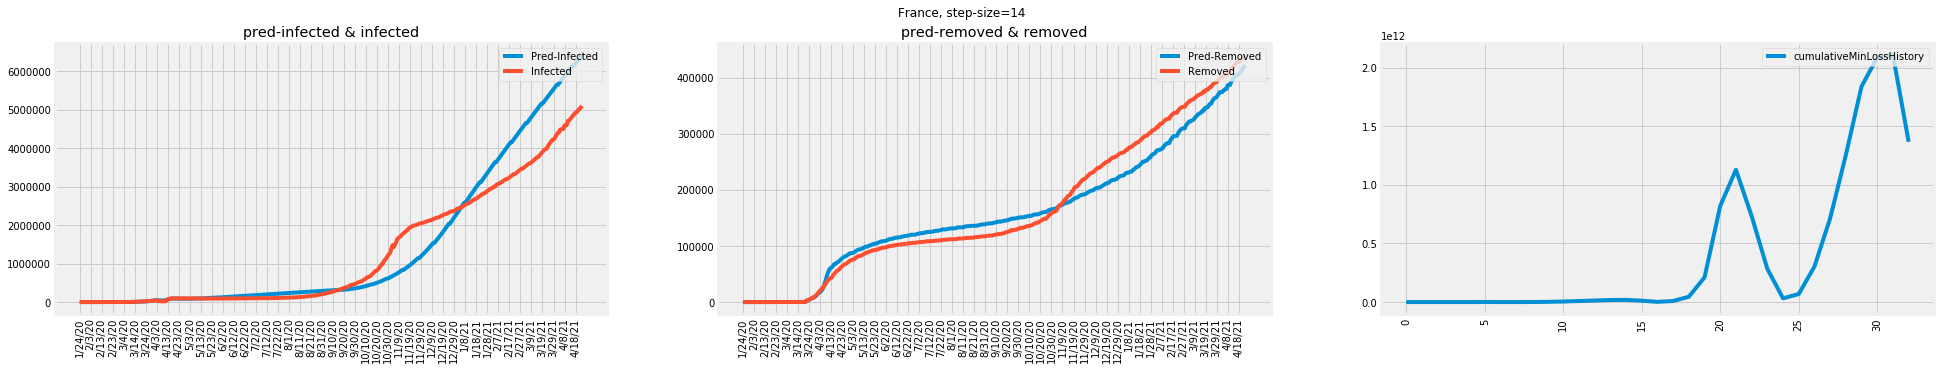

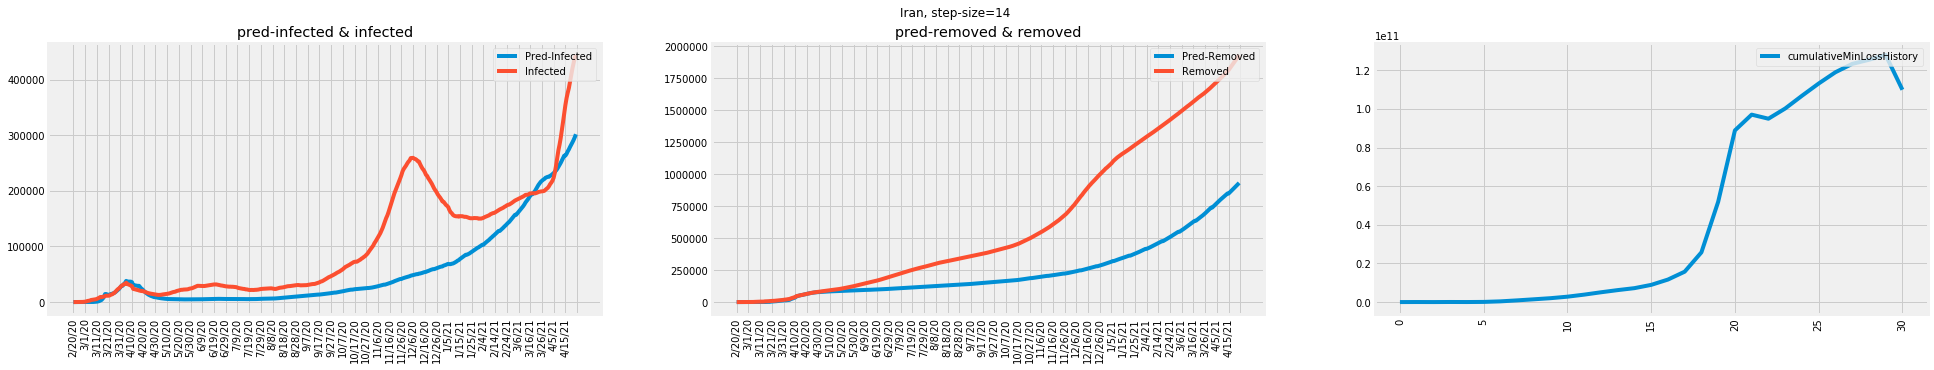

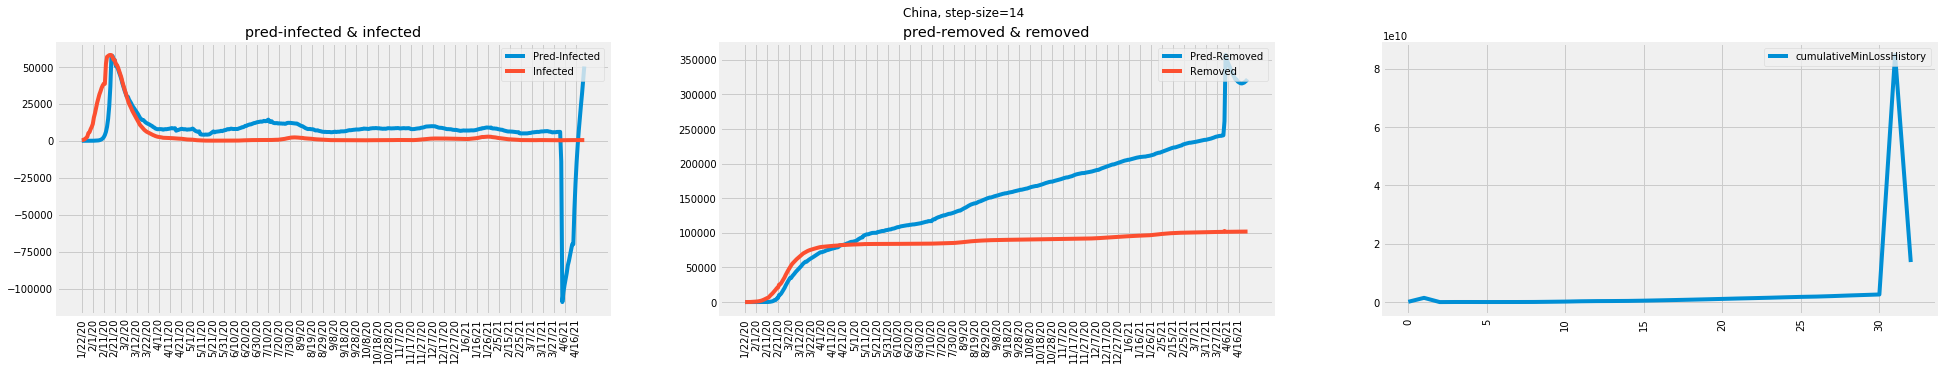

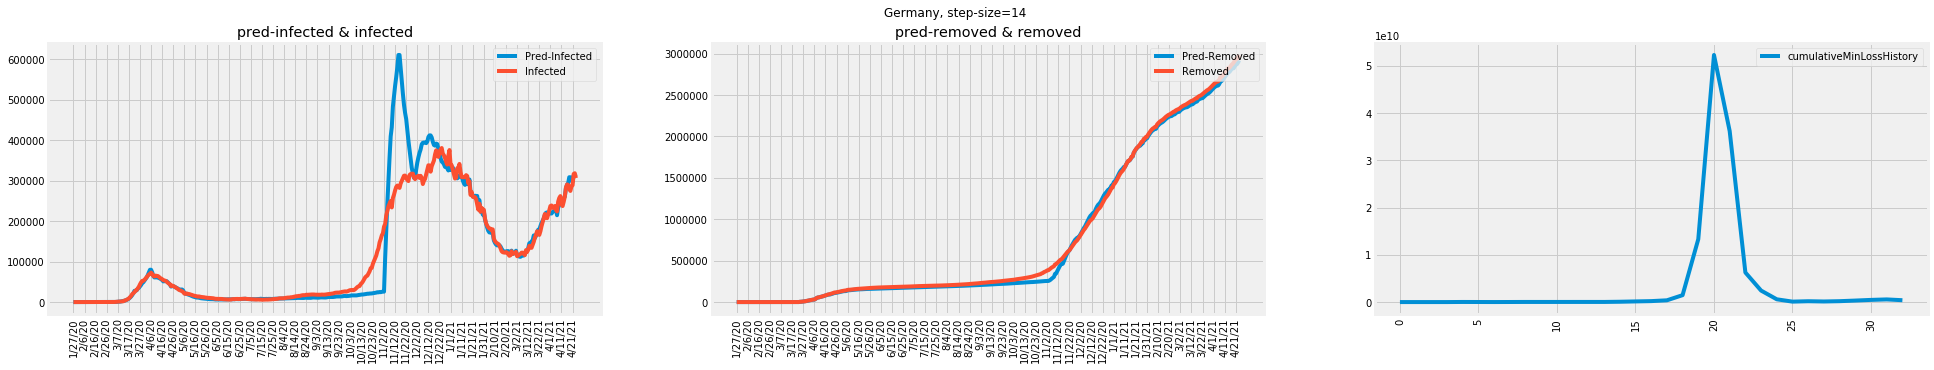

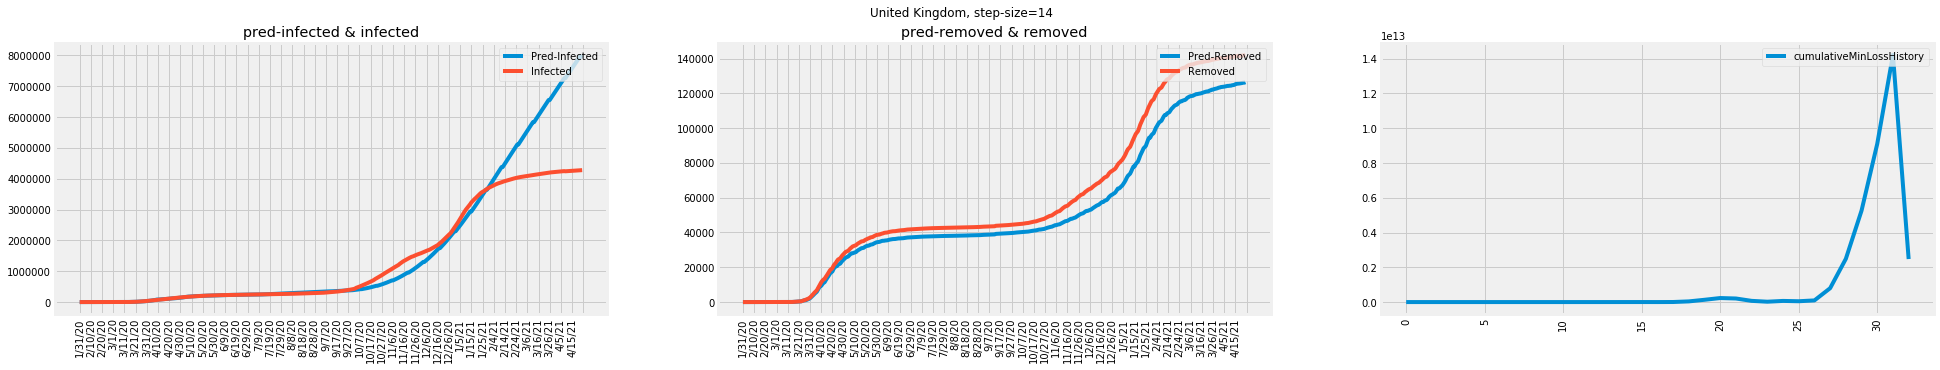

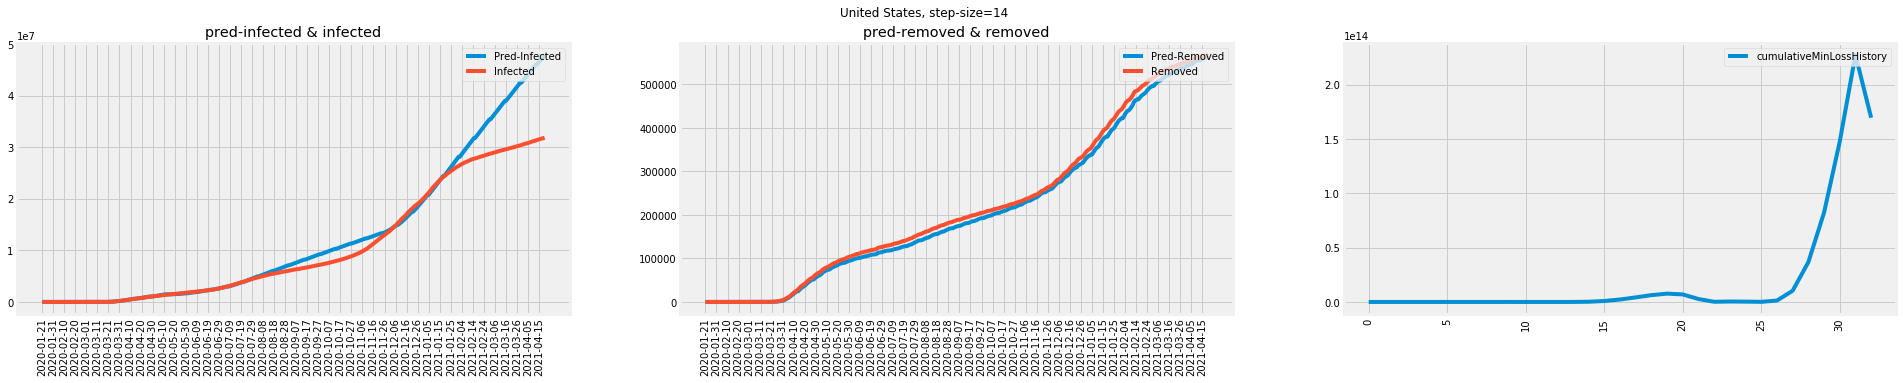

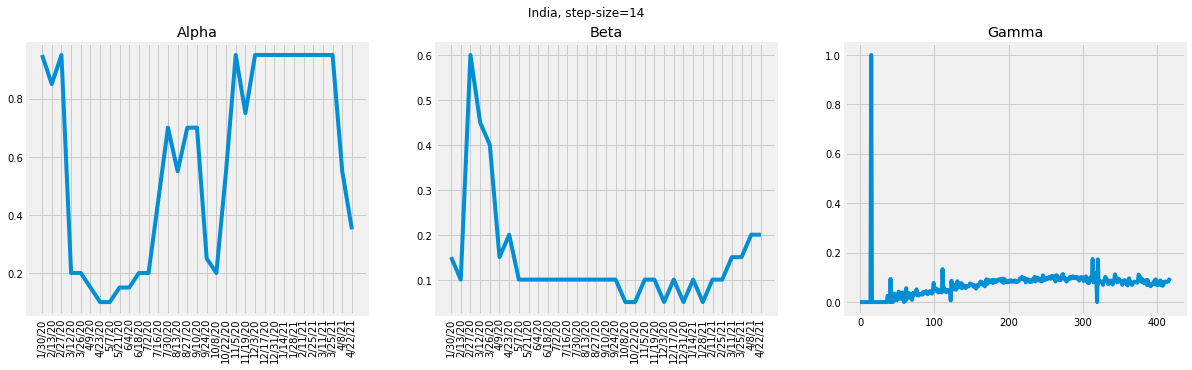

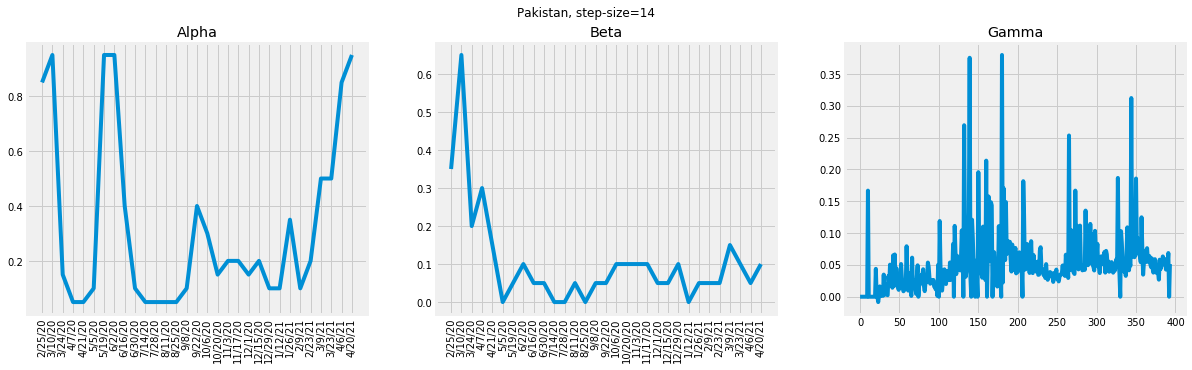

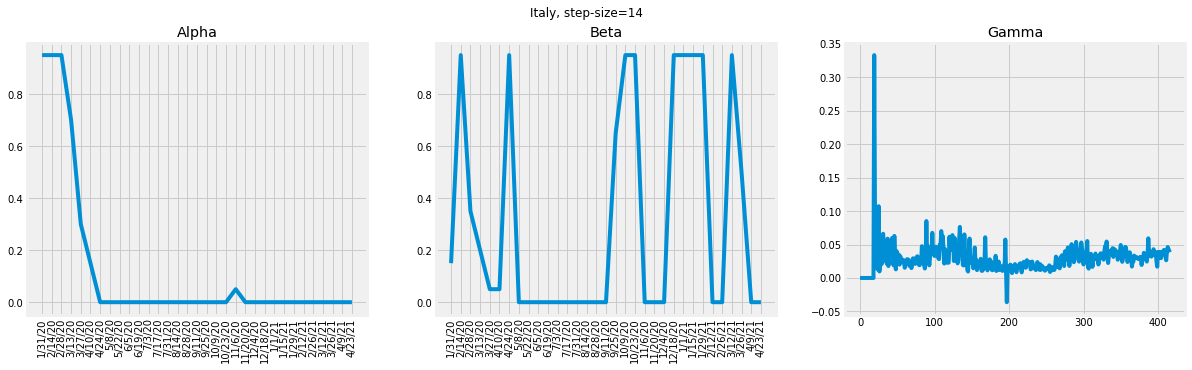

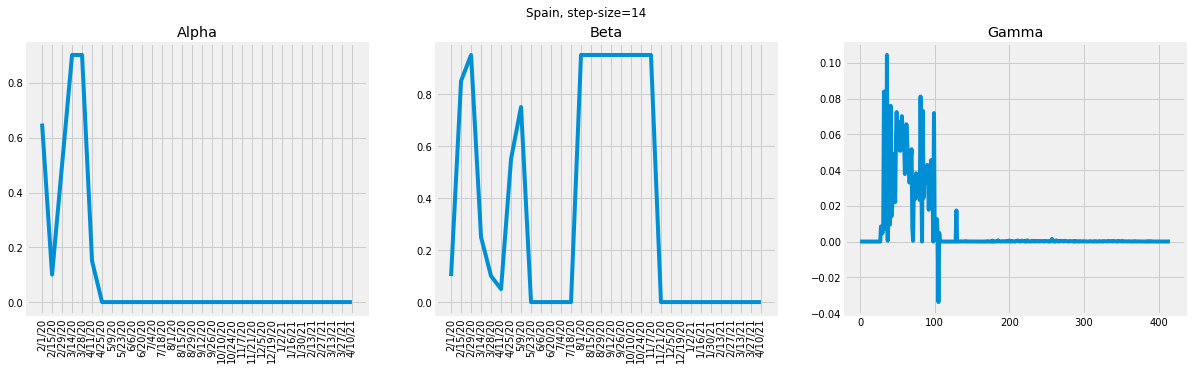

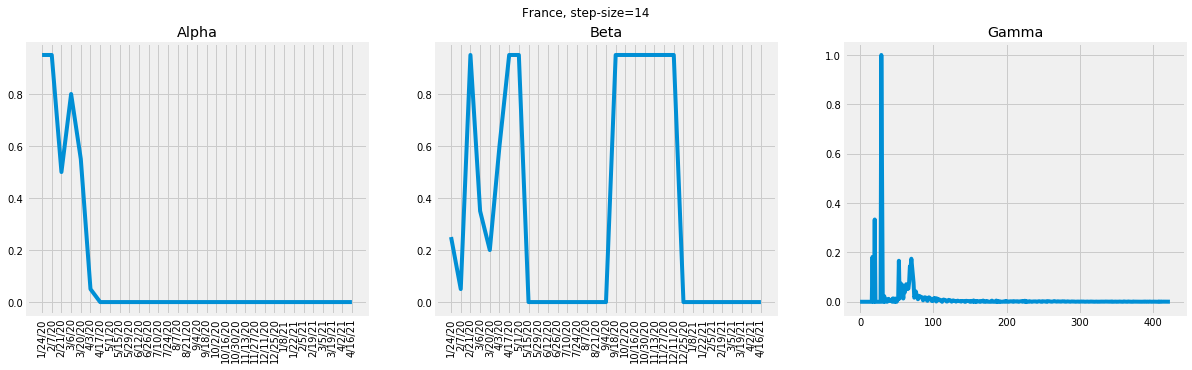

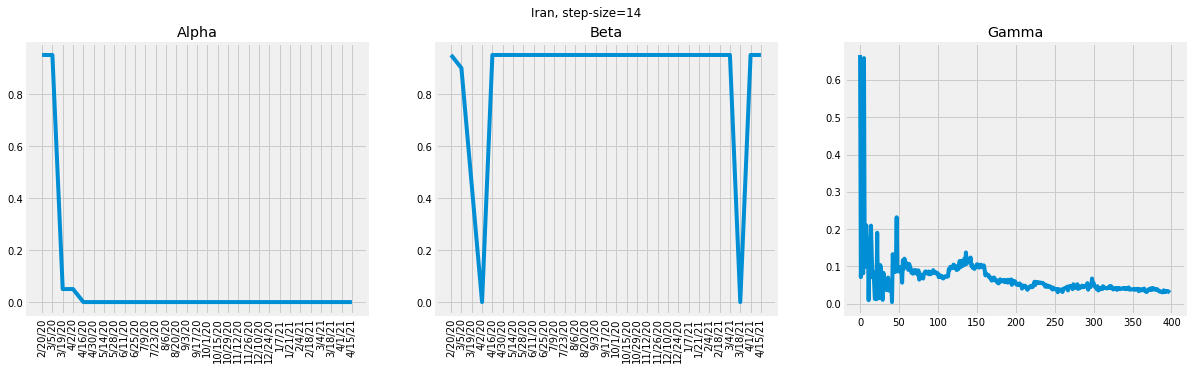

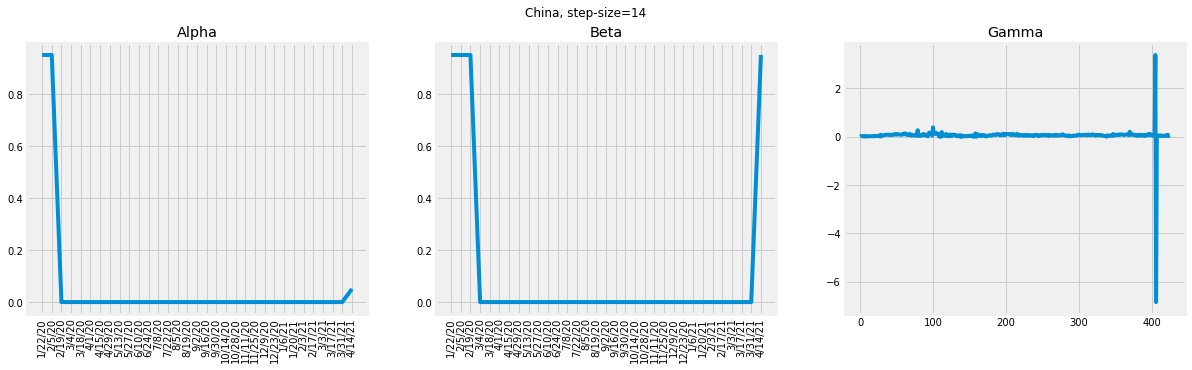

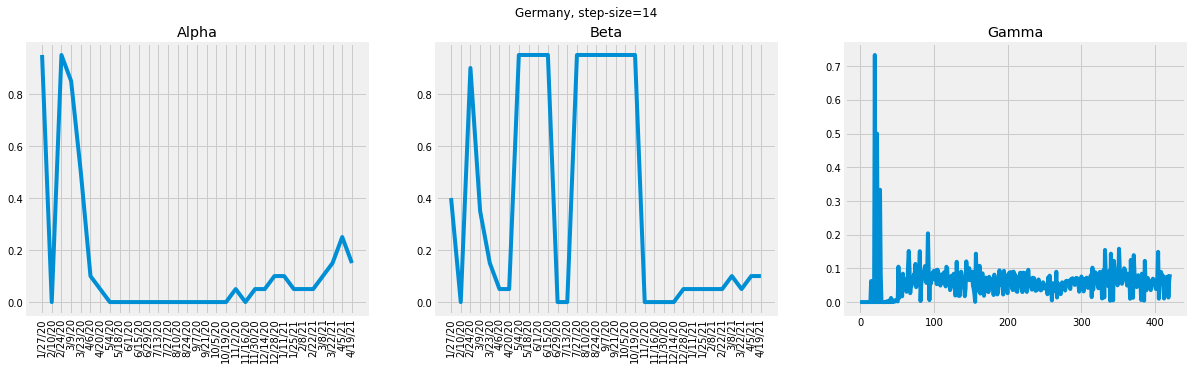

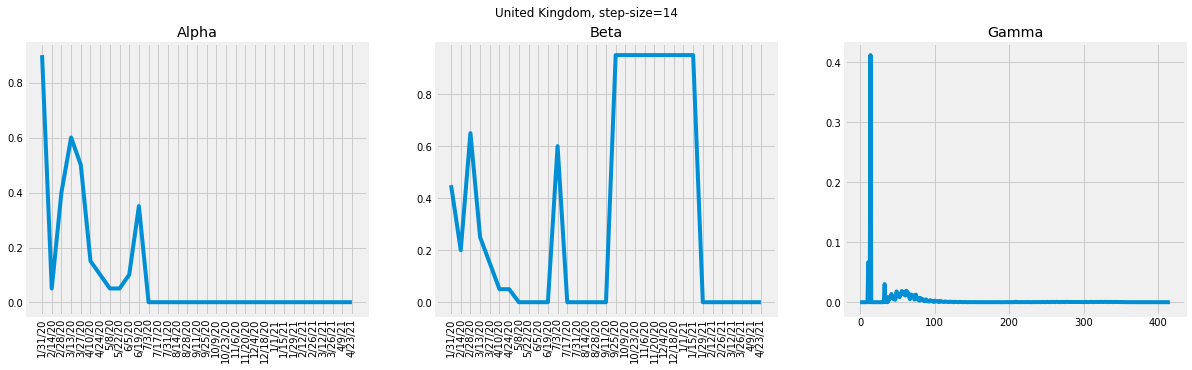

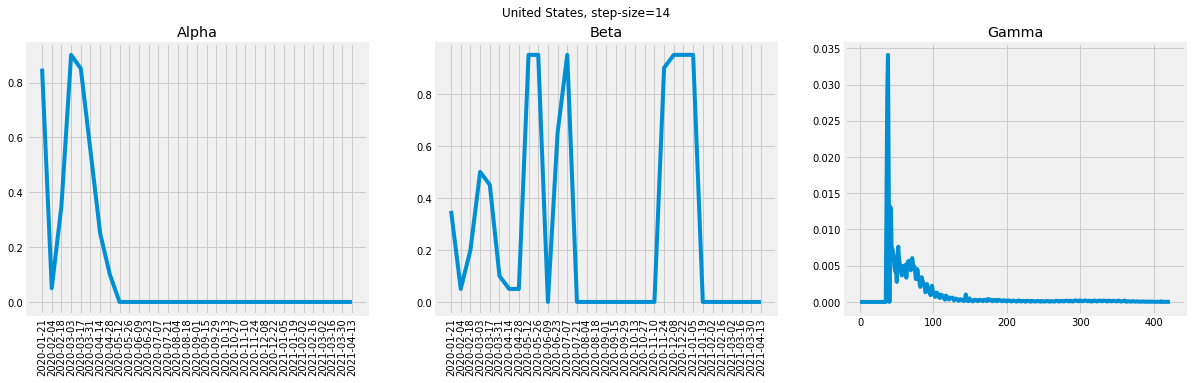

In [11]:
jobs = []
for stepSize in stepSizesToRunFor:
    computeParamsWithStepSize(stepSize, False)
#     p = multiprocessing.Process(target=computeParamsWithStepSize, args=(stepSize, ))
#     jobs.append(p)
#     p.start()

In [12]:
from sklearn import preprocessing
# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(1,10))
cumulativeLossDf['Accuracy_Score'] = min_max_scaler.fit_transform(cumulativeLossDf['Accuracy_Score'].values.reshape(-1, 1))
cumulativeLossDf[cumulativeLossDf['Accuracy_Score'] == 0] = 0.0001
cumulativeLossDf['Accuracy_Score'] = 1/cumulativeLossDf['Accuracy_Score']

display(cumulativeLossDf)
cumulativeLossDf_group_by_stepSize = cumulativeLossDf.groupby('Step_Size').min()
cumulativeLossDf_group_by_stepSize = pd.DataFrame(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize)
display(cumulativeLossDf_group_by_stepSize.loc[cumulativeLossDf_group_by_stepSize['Accuracy_Score'].idxmax() ])

Country  Accuracy_Score  Step_Size
0   India           0.730310       -1.0      
1   Pakistan        0.999318       -1.0      
2   Italy           0.981465       -1.0      
3   Spain           0.911877       -1.0      
4   France          0.858138       -1.0      
5   Iran            0.994310       -1.0      
6   China           0.999932       -1.0      
7   Germany         0.992079       -1.0      
8   United Kingdom  0.851445       -1.0      
9   United States   0.100000       -1.0      
10  India           0.993221        7.0      
11  Pakistan        0.999944        7.0      
12  Italy           0.997165        7.0      
13  Spain           0.985641        7.0      
14  France          0.977684        7.0      
15  Iran            0.999893        7.0      
16  China           0.999988        7.0      
17  Germany         0.997335        7.0      
18  United Kingdom  0.965551        7.0      
19  United States   0.567768        7.0      
20  India           0.715123        21.0     
21  Pakistan        0.999991        21.0     
22  Italy           0.993427        21.0     
23  Spain           0.859476        21.0     
24  France          0.976218        21.0     
25  Iran            0.999978        21.0     
26  China           0.999991        21.0     
27  Germany         0.999967        21.0     
28  United Kingdom  0.954784        21.0     
29  United States   0.483402        21.0     
30  India           0.998713        14.0     
31  Pakistan        1.000000        14.0     
32  Italy           0.998860        14.0     
33  Spain           0.974479        14.0     
34  France          0.977469        14.0     
35  Iran            0.997630        14.0     
36  China           0.999780        14.0     
37  Germany         0.999798        14.0     
38  United Kingdom  0.941563        14.0     
39  United States   0.445371        14.0

Country  Accuracy_Score
Step_Size                        
-1.0       China   0.100000      
 7.0       China   0.567768      
 14.0      China   0.445371      
 21.0      China   0.483402

Country           China   
Accuracy_Score    0.567768
Name: 7.0, dtype: object